# Structure Archetypes - Ouray County Parcel Risk
**Author:** Bryce A Young  
**Created:** 2025-03-10 | 
**Modified:** 2025-03-11  

#### Overview
In this notebook, I analyze the clusters created in `clustering.ipynb`, also located in this repository. Analysis is unstructured. The objective is to pull out salient features that describe clusters in the dataset. The final product should be a set of home archetypes that can be described broadly (e.g. old homes with high structure density, large homes with wooden roofs on large properties, etc.). Ideally, I would be able to assign each structure type a range of fuel volumes that the structure and its defensible space can assume (this will make my segmentation more applicable to WUI fire spread modeling).

I analyze cluster segmentation by HIZ and structure features. I describe segmented clusters. I join the clusters to the building geopackage to map structure locations by cluster (this last part is conducted in ArcGIS Pro).

## Environment Setup
---

In [1]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# Any final outputs go here
out = os.path.join(data, '_out')
# Figures to export
figs = os.path.join(out, 'figures')

# correct working directory
os.getcwd()

'D:\\_PROJECTS\\P001_OurayParcel\\ouray'

In [3]:
import pandas as pd

pd.set_option('display.max_columns', None)

full_df = pd.read_csv(os.path.join(out, 'df_feat_clusters.csv'))
full_df.columns

Index(['Unnamed: 0', 'rwra_index', 'feat_index', 'parcel_num', 'Year',
       'address', 'ParcelNum', 'Model', 'Address_Visible',
       'Driveway_Clearance', 'Driveway_Lenth', 'Dist_to_Danger_Topo',
       'Slope_Final', 'Background_Fuels', 'Defensible_Space',
       'Roofing_Material', 'Building_Exterior', 'Other_Combustibles',
       'Decks_and_Fencing', 'Proximity_to_Neighboring_Home', 'Ingress_Egress',
       'Score_Final', 'Risk_Rating', 'County', 'wui_class', 'min_ssd',
       'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m',
       'intersections', 'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'tax_AIRC', 'tax_ARCH', 'tax_SQFT', 'tax_COND', 'tax_EYB',
       'tax_EXW_PERCENT', 'tax_EXW', 'tax_FLR', 'tax_FRME', 'tax_HTFL',
       'tax_INT', 'tax_RMS', 'tax_RCVR', 'tax_RSTR', 'Type', 'sum_cc',
       'tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP', 'Risk_Rating_new',
       'At_Least_8_Unobserved', 'wui_class_3', 'wui_class_5', 'wui_class_6',
       'tax_ARCH_C

## Analysis of Spectral Clusters
---

In [7]:
spc = []

# Loop through files in the directory
for i in range(12):  # since files are named 'spectral_cluster_{i}.csv'
    filename = f"spectral_cluster_{i}.csv"
    filepath = os.path.join(out, filename)
    
    if os.path.exists(filepath):  # Ensure file exists before reading
        df = pd.read_csv(filepath)
        print(f'cluster {i} size: {len(df)}')
        spc.append(df)

cluster 0 size: 195
cluster 1 size: 149
cluster 2 size: 327
cluster 3 size: 6
cluster 4 size: 3
cluster 5 size: 191
cluster 6 size: 2
cluster 7 size: 5
cluster 8 size: 86
cluster 9 size: 387
cluster 10 size: 24
cluster 11 size: 17


I have 12 spectral clusters. Clusters 3, 4, 6, 7 are too small to be useful. I am going to treat them as noise, dropping them entirely. The clusters will them be reindexed in the spc list.

In [ ]:
to_drop = {3, 4, 6, 7}

spc = [df for i, df in enumerate(spc) if i not in to_drop]

for idx, df in enumerate(spc):
    print(f'cluster {idx} size: {len(df)}')

cluster 0 size: 195
cluster 1 size: 149
cluster 2 size: 327
cluster 3 size: 191
cluster 4 size: 86
cluster 5 size: 387
cluster 6 size: 24
cluster 7 size: 17


Now we have 8 clusters, having jettisoned 16 observations between the 4 noise clusters.

Below, we examine the clusters in greater detail. First, we segement different column types to organize the analysis.

In [14]:
# These cols were used for clustering
c_cols = [
    'tax_EXW_MANFCTD',
       'tax_EXW_WOOD', 'tax_RCVR_METAL', 'tax_RCVR_OTHER', 'tax_RCVR_TILE',
       'tax_RCVR_WOOD', 'tax_RSTR_MANSARD', 'tax_RSTR_MULTI_PEAK',
       'tax_RSTR_OTHER', 'tax_RSTR_SHED', 'fc2m', 'fc4m', 'fc8m', 'fc8m+',
       'wui_class_3', 'wui_class_5', 'wui_class_6',
       'intsc_class', 'acre_class', 'sqft_class', 'ssd_class', 'eyb_class',
       'tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP'
]

# Numerical columns
num_cols = [
    'wui_class',
       'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m',
       'intersections'
]

# Categorical columns
cat_cols = [
    'tax_SQFT', 'tax_ARCH', 'min_ssd', 'tax_RCVR', 'tax_RSTR', 'Risk_Rating', 'Risk_Rating_new'
]

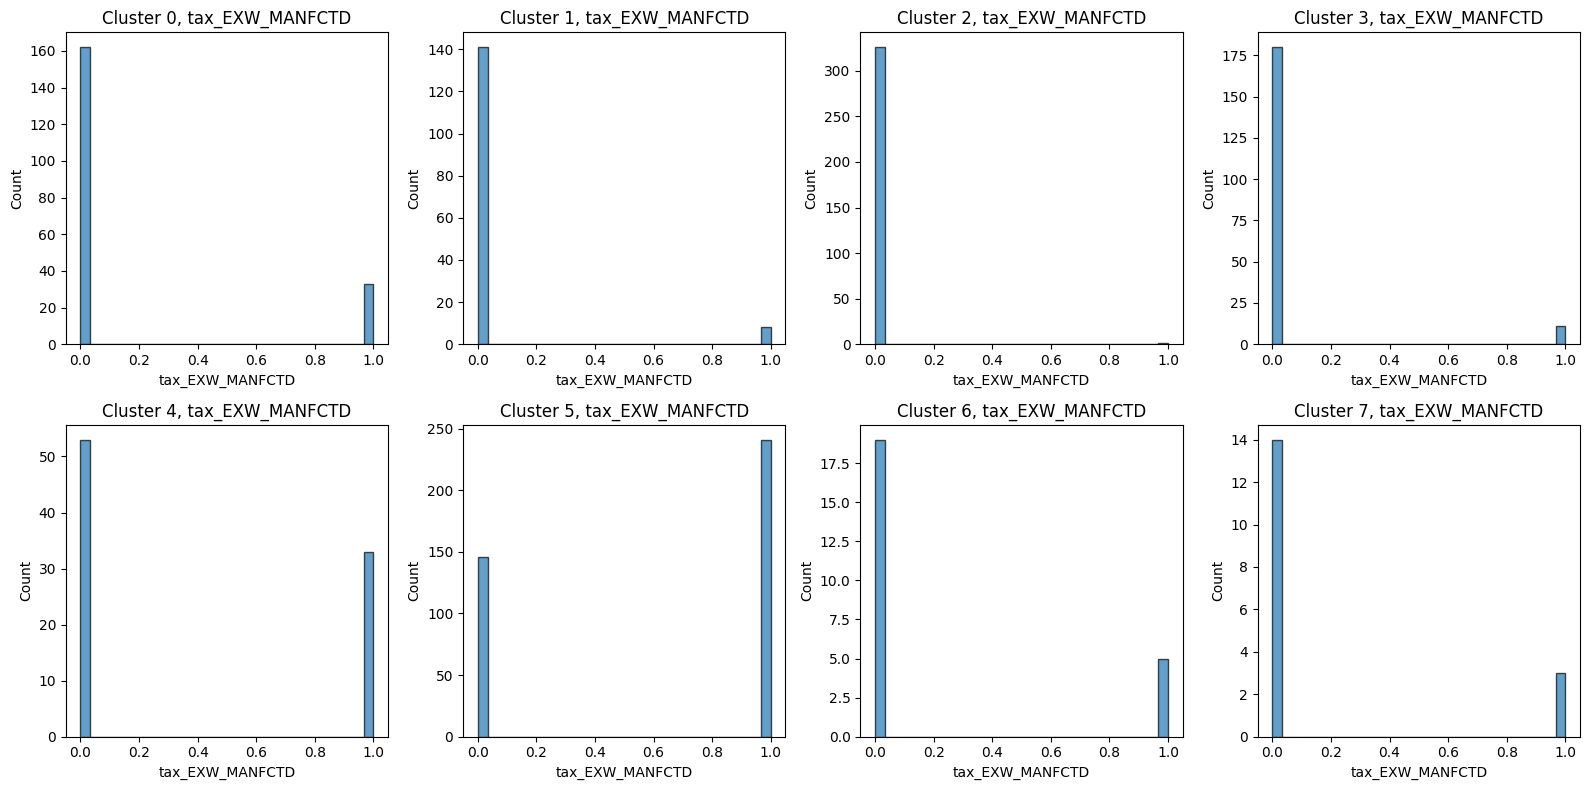

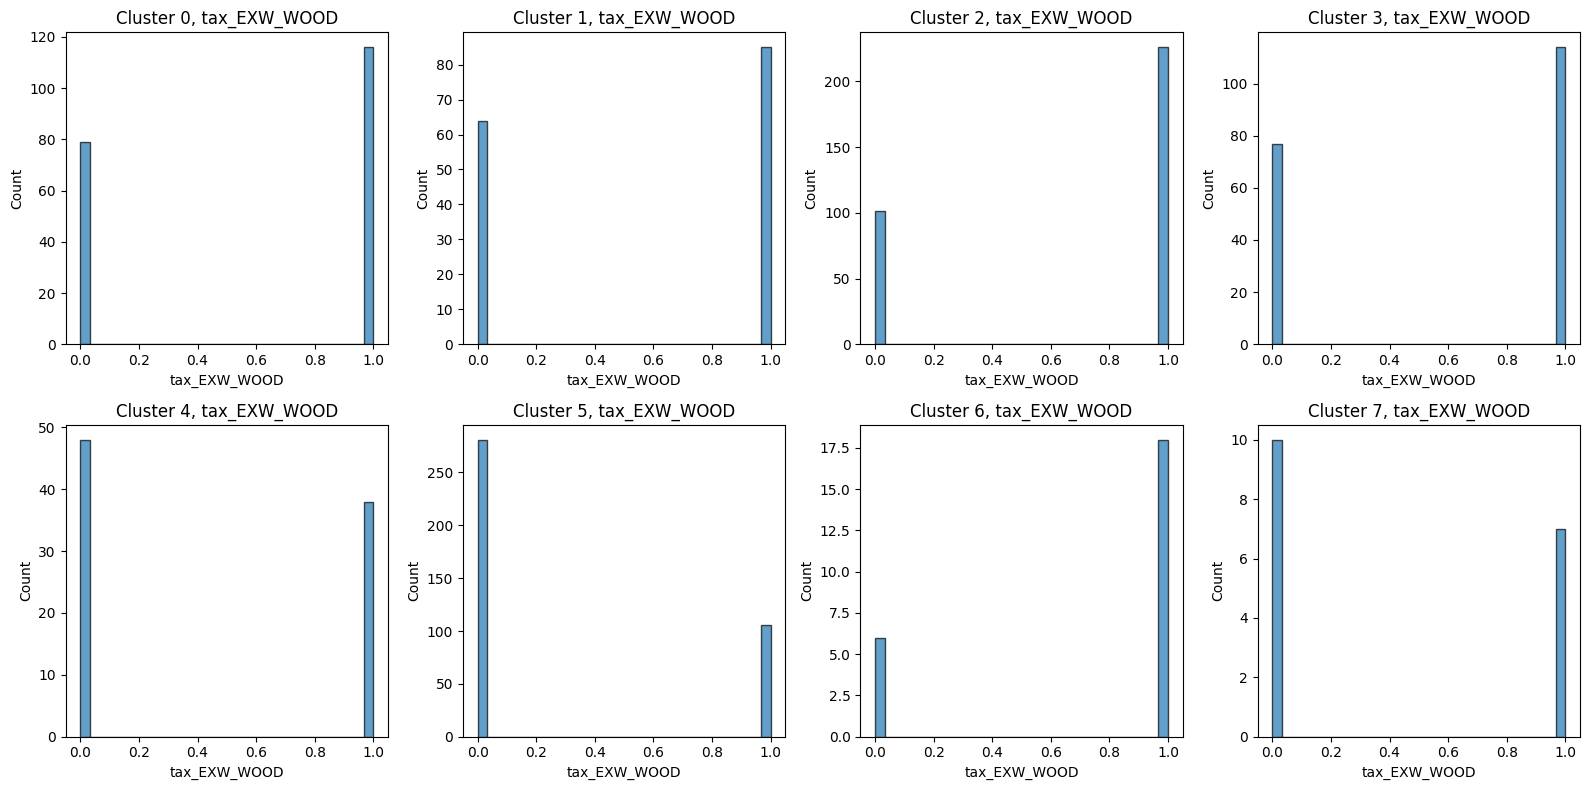

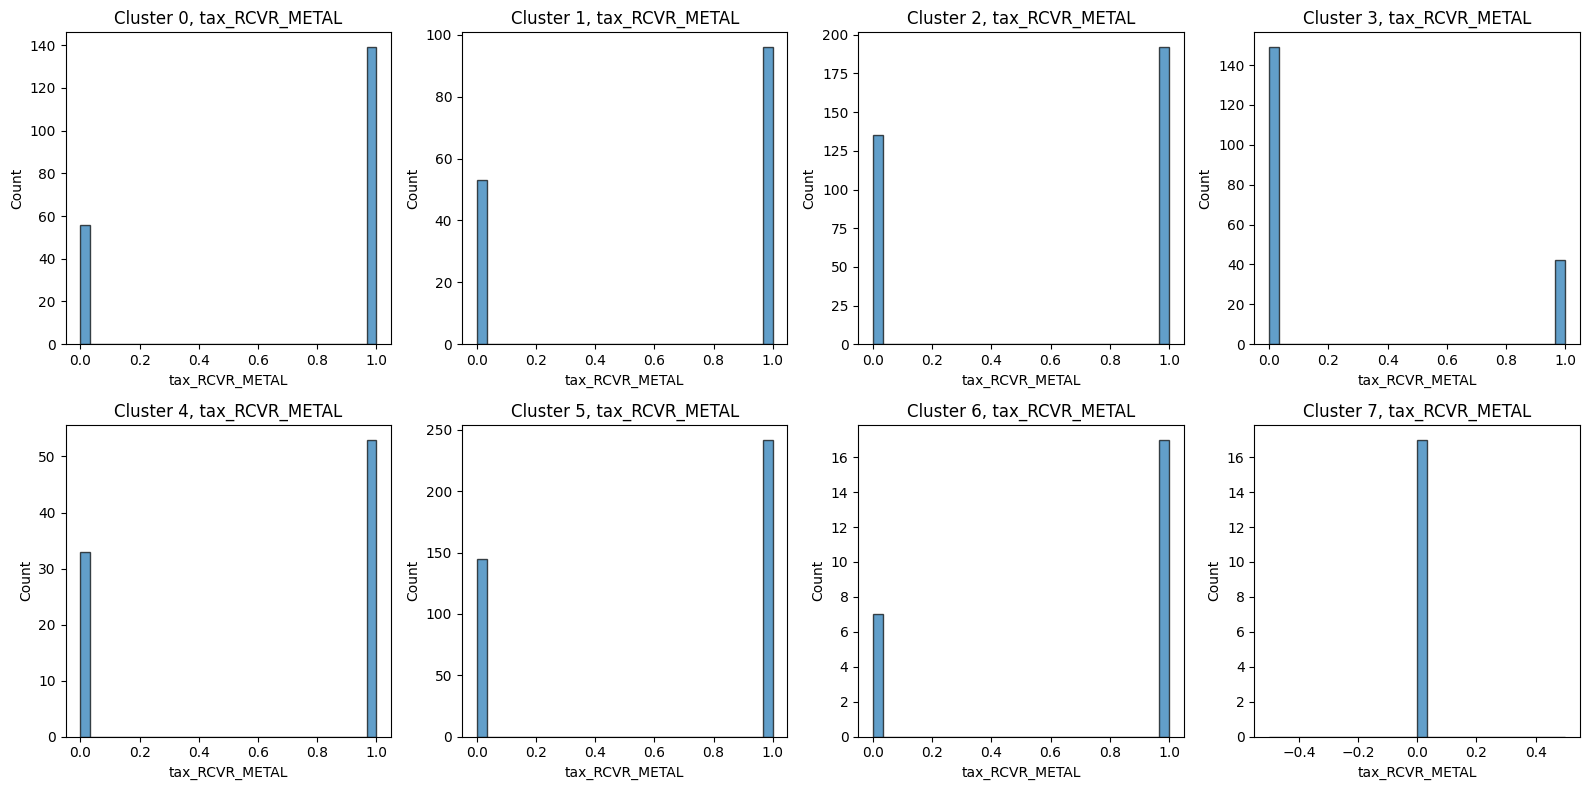

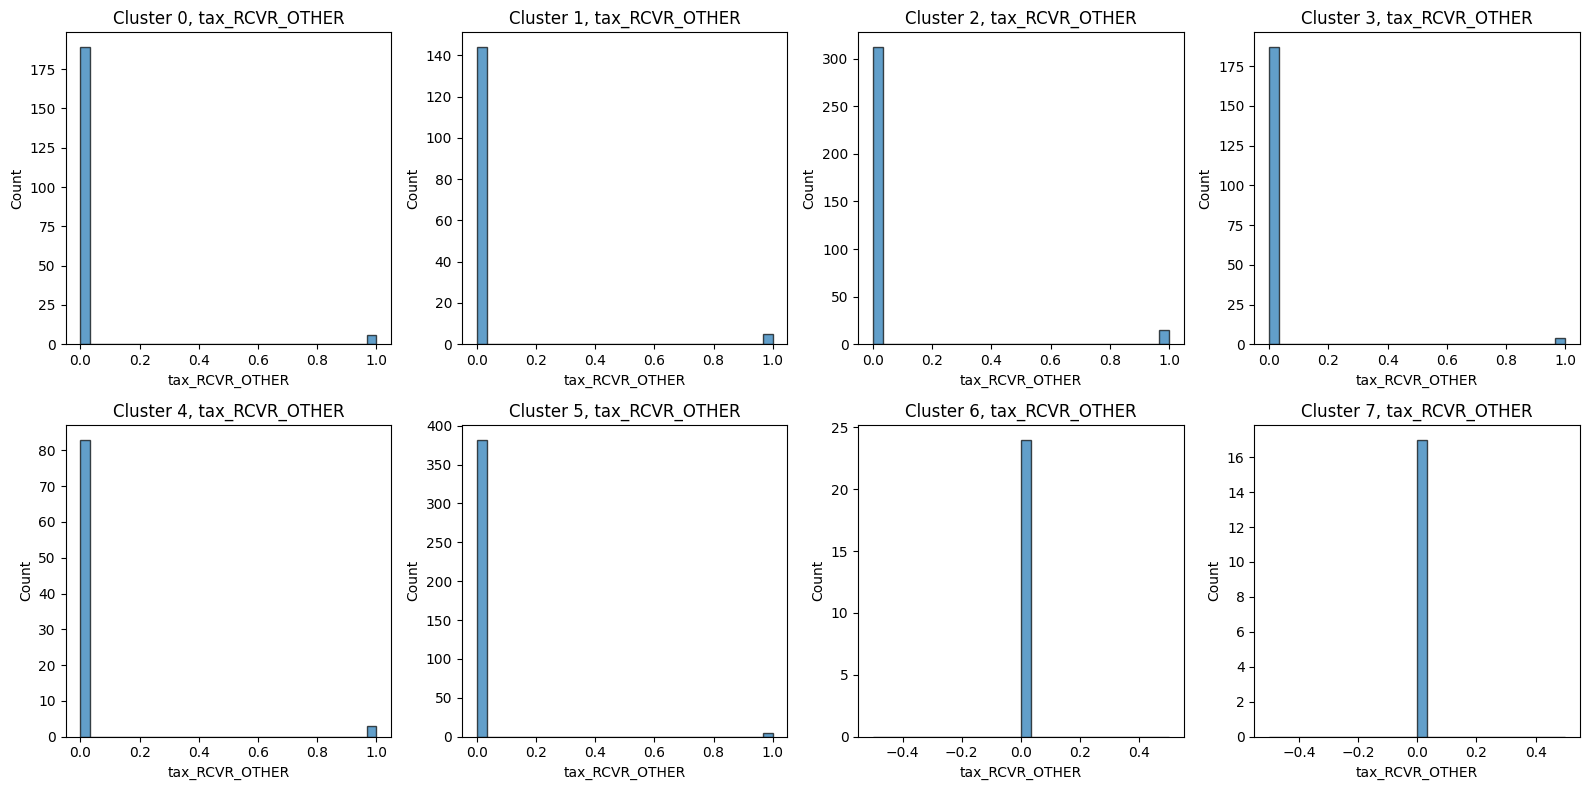

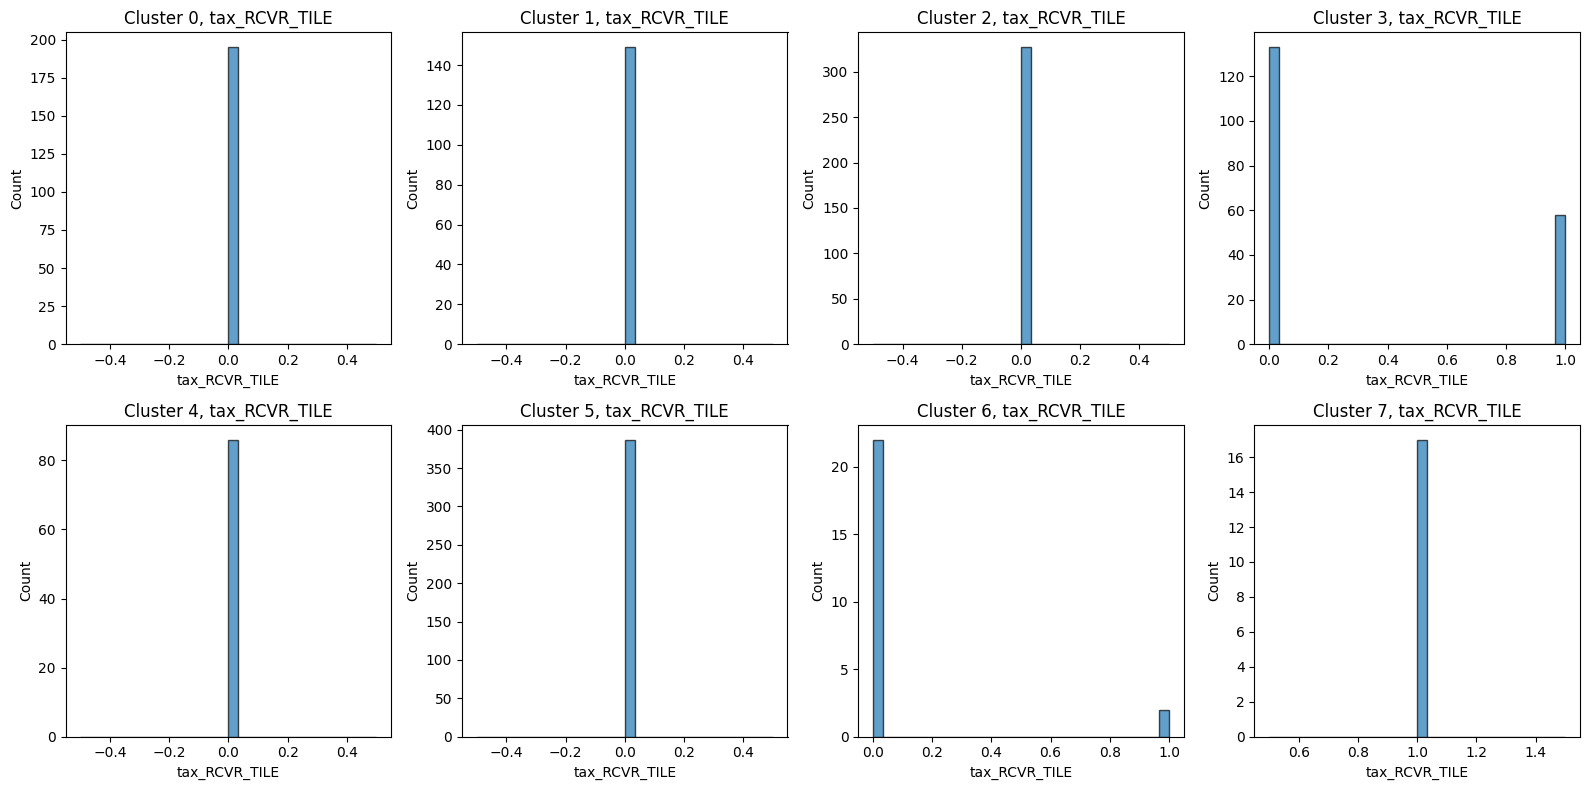

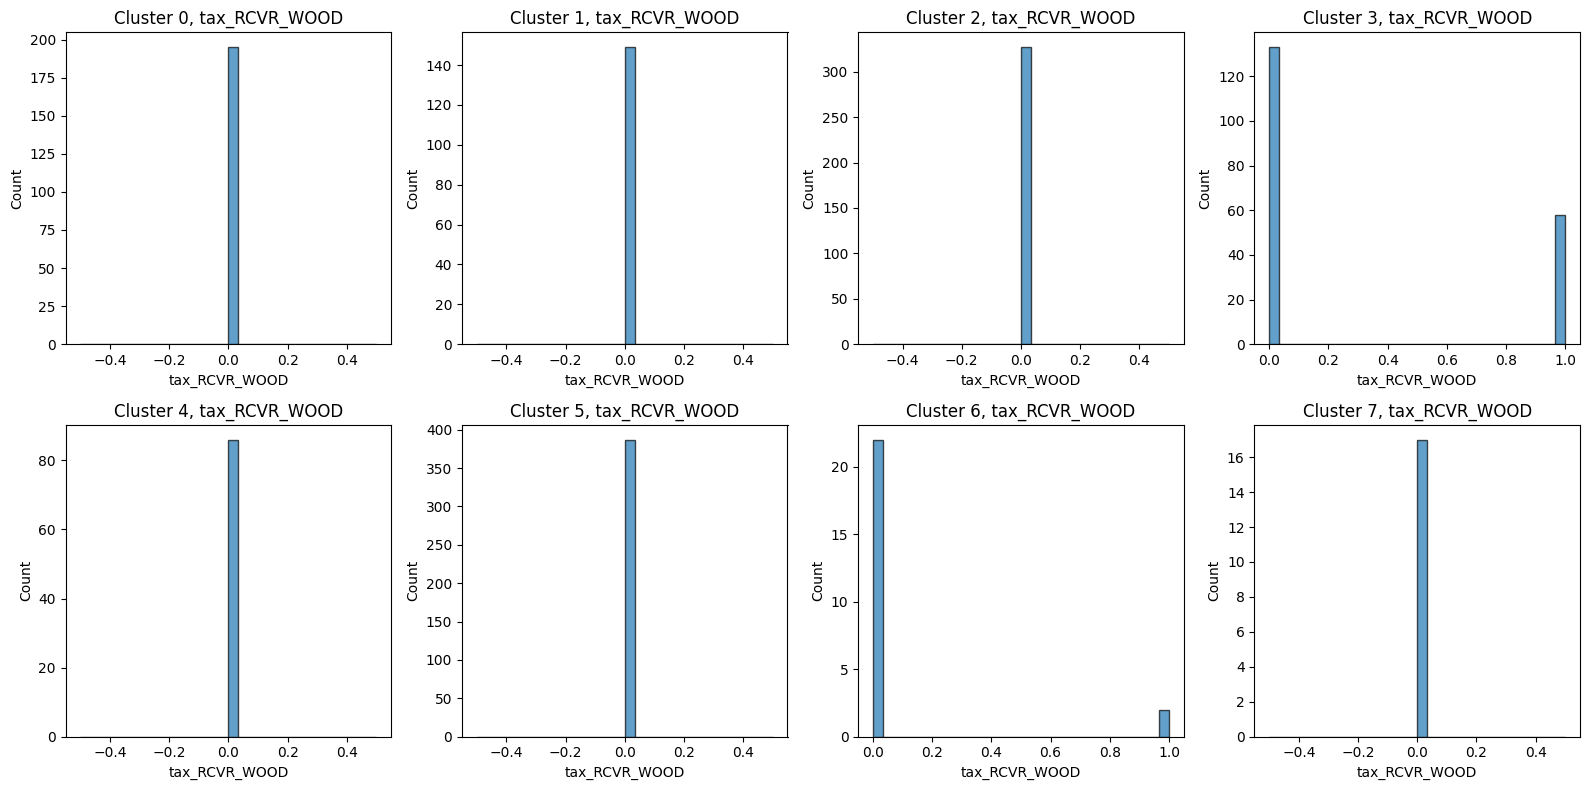

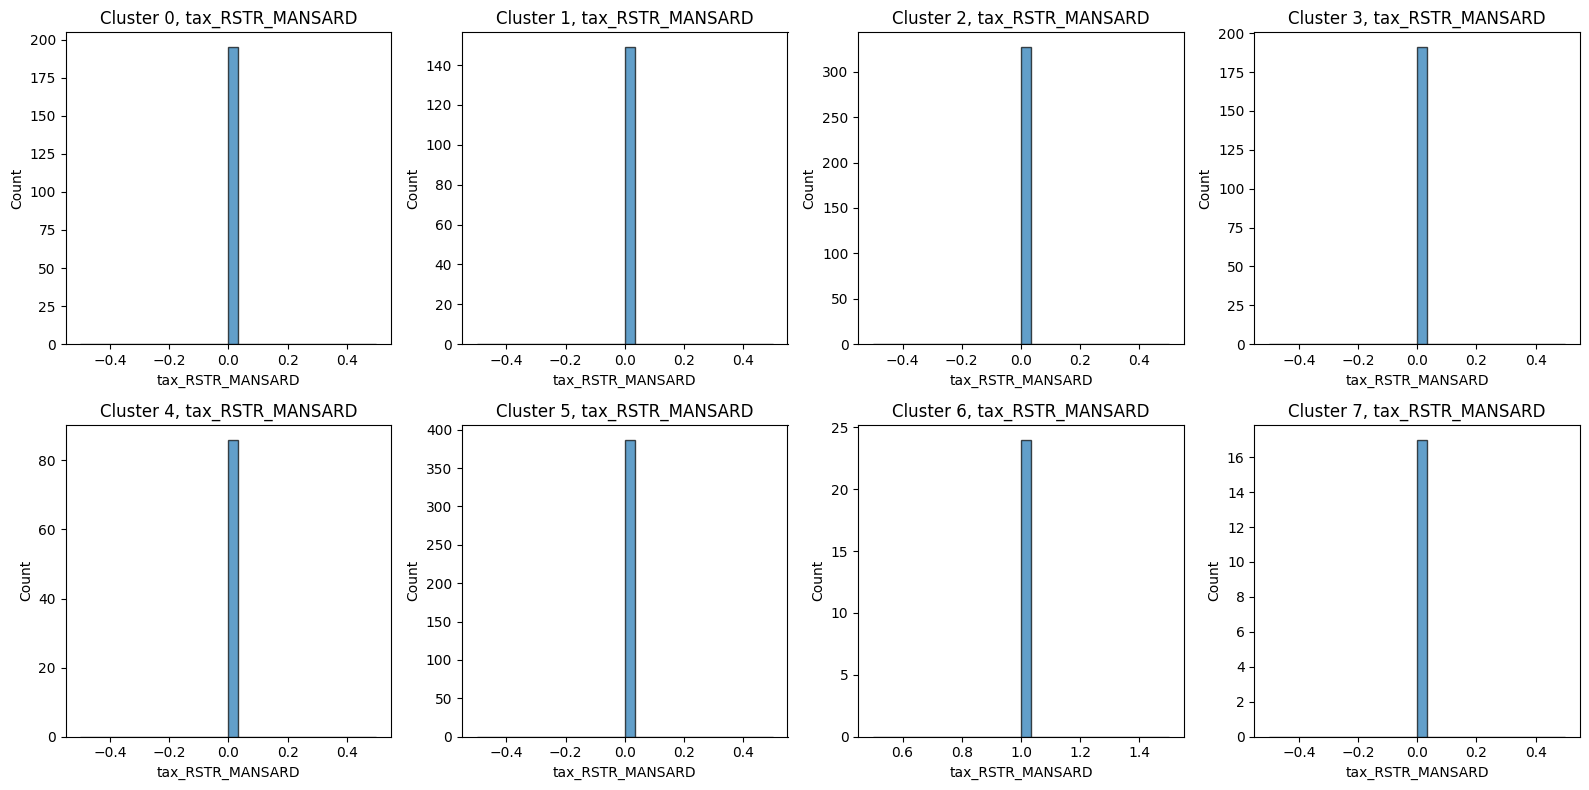

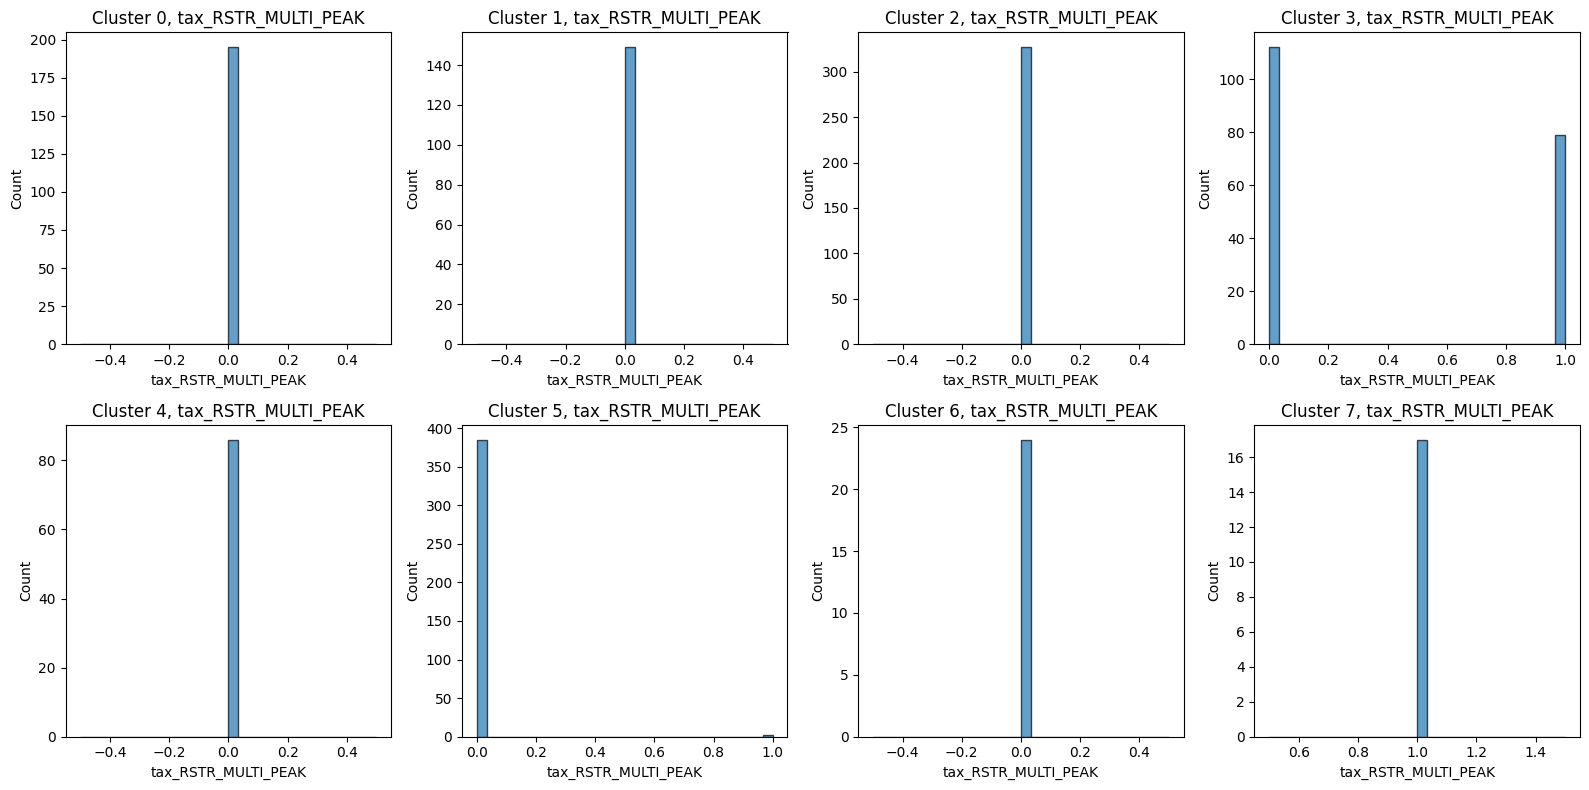

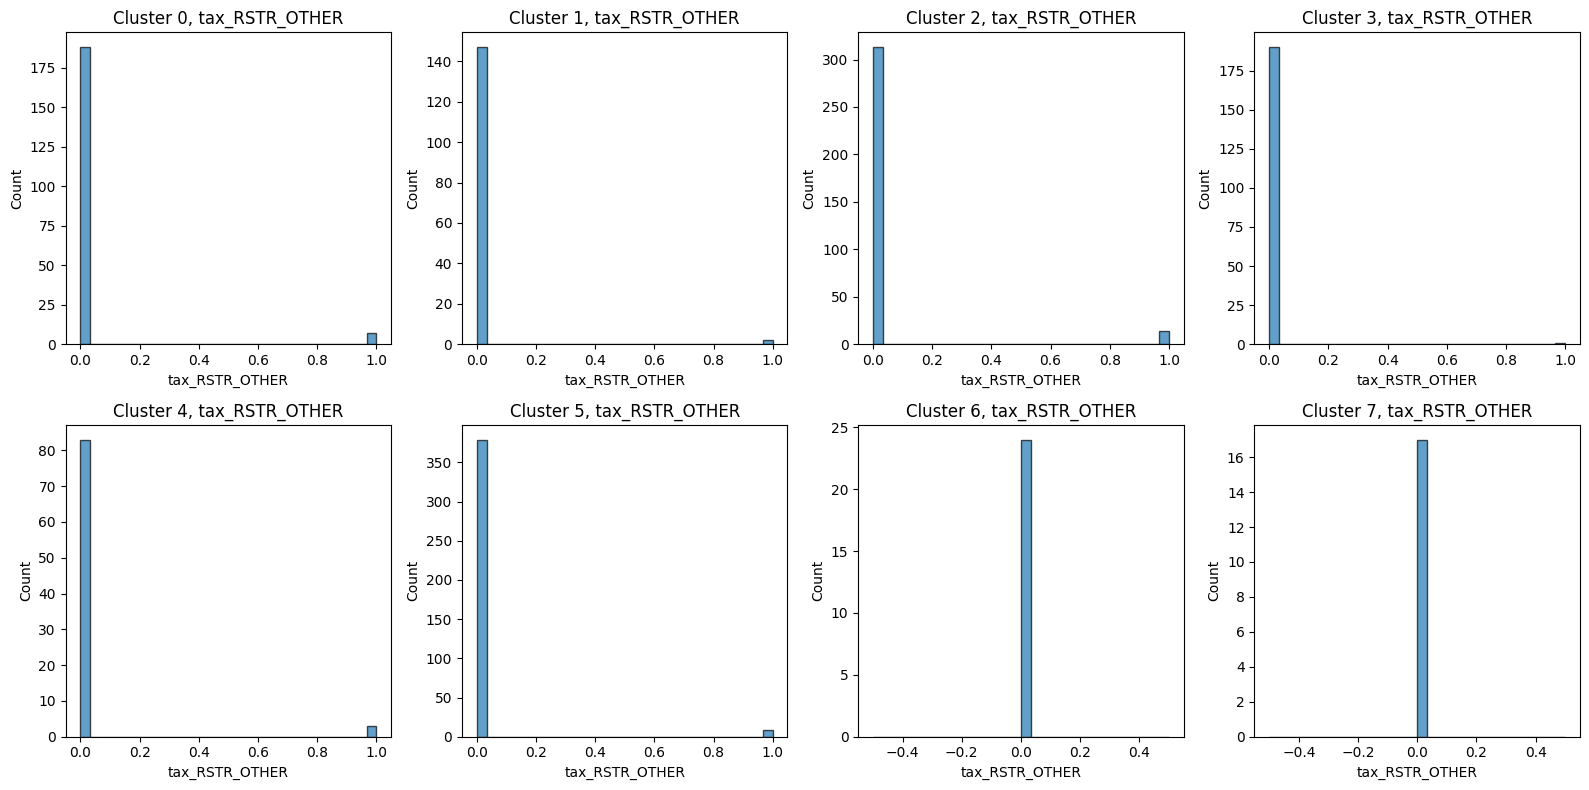

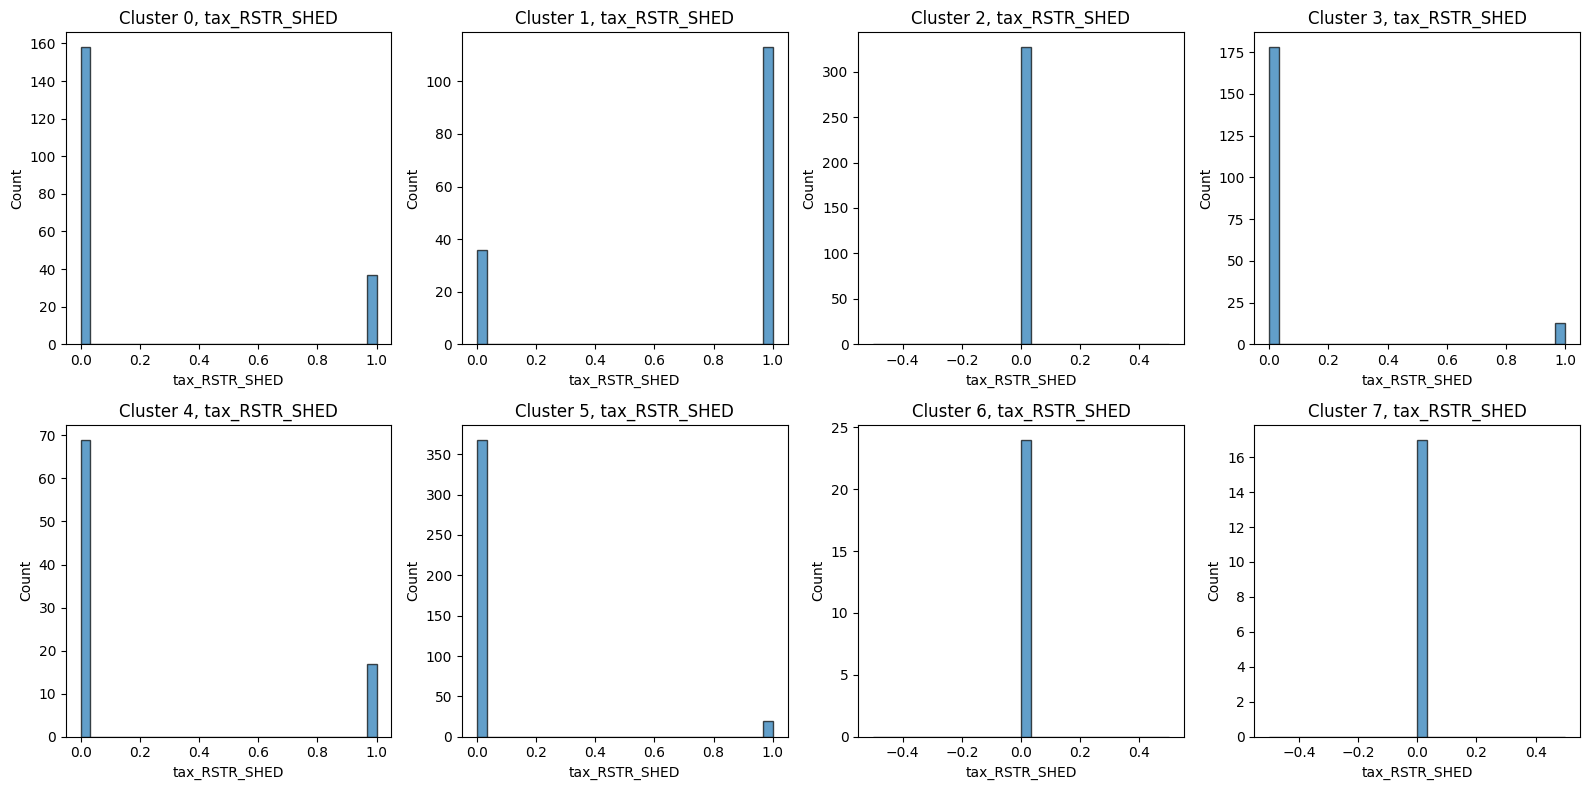

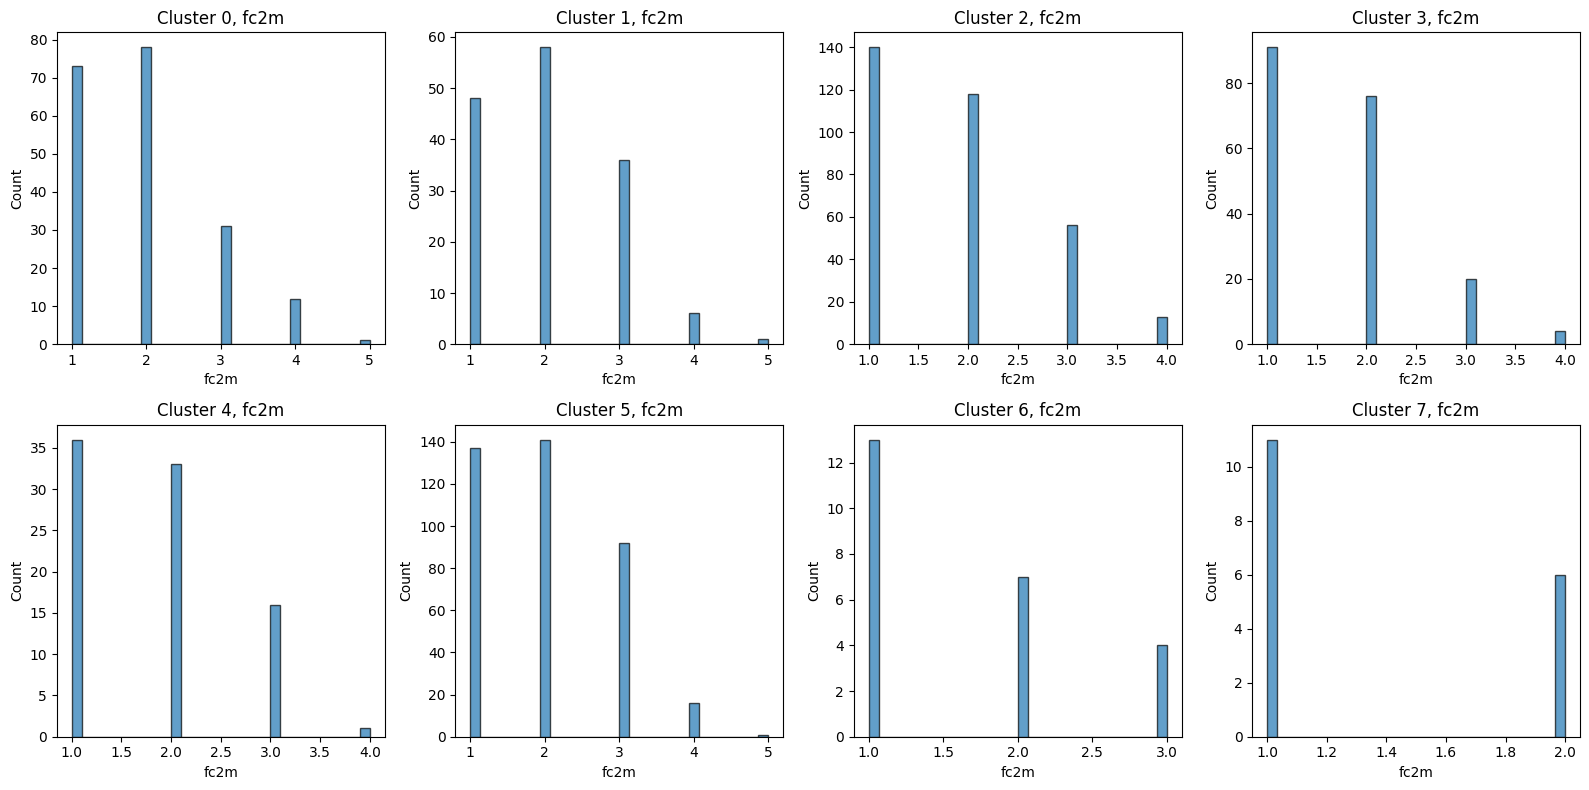

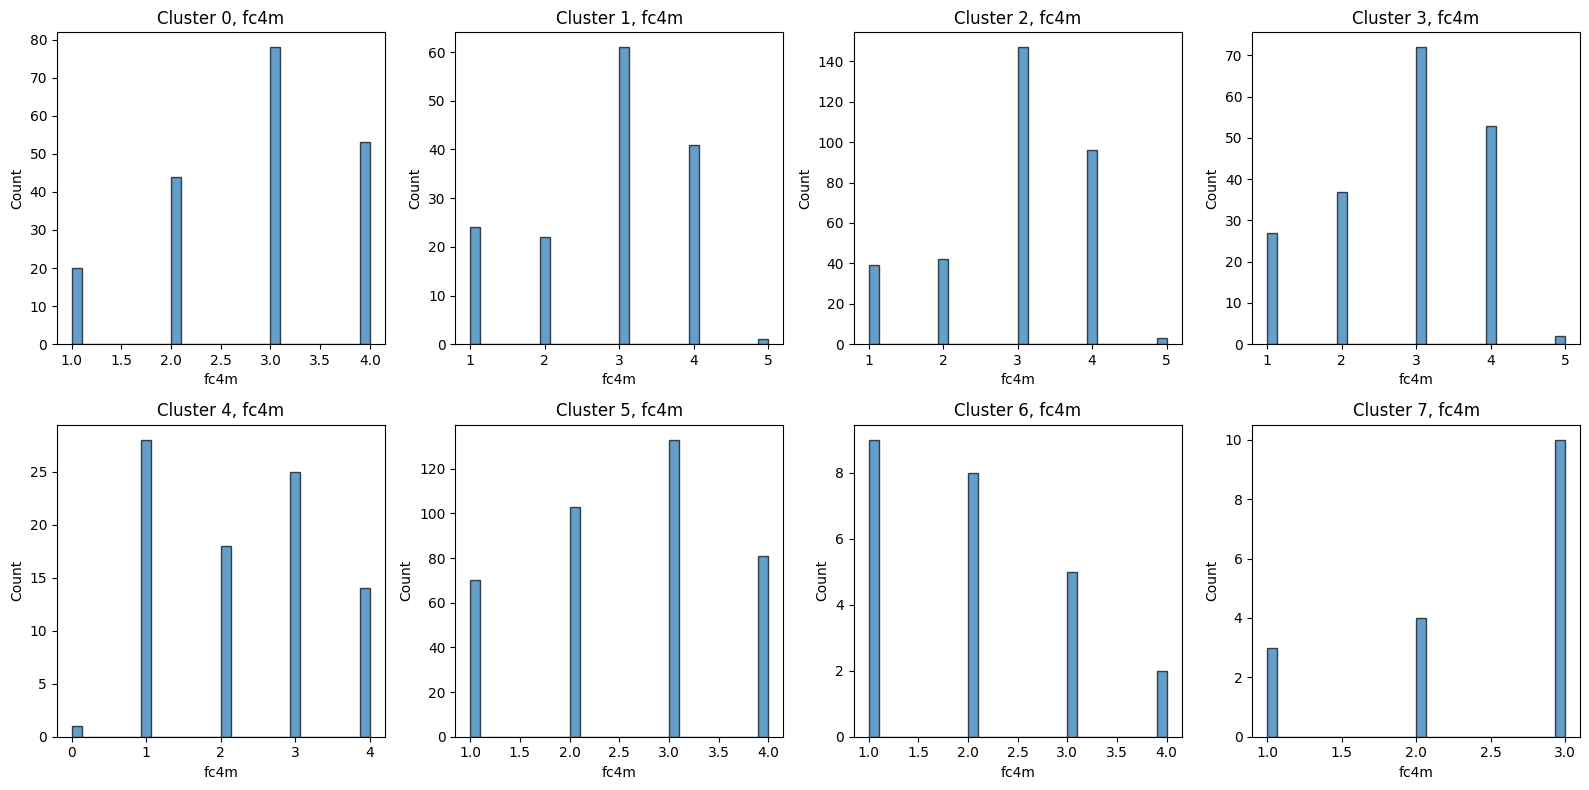

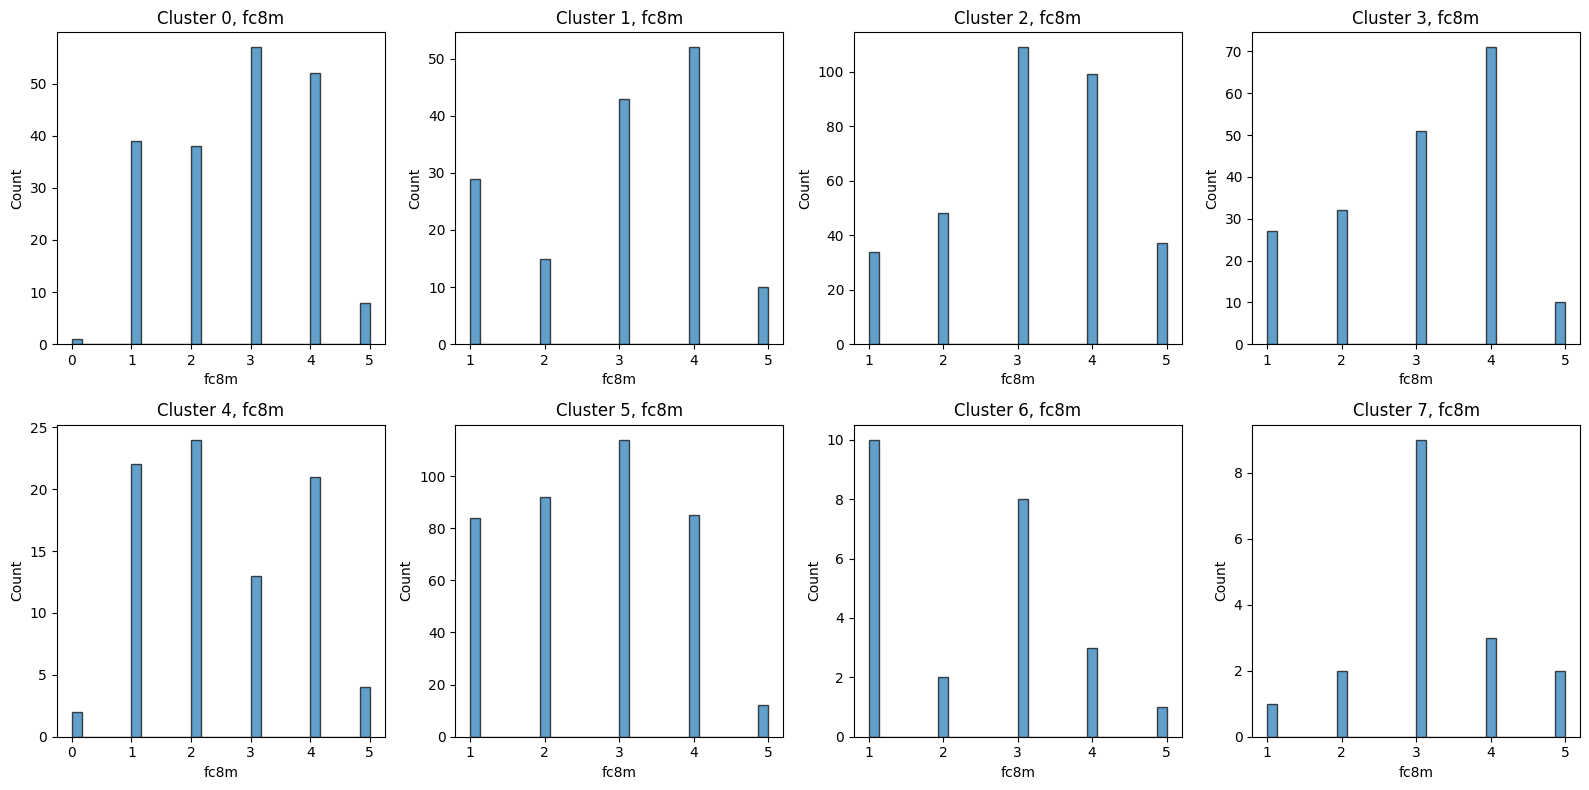

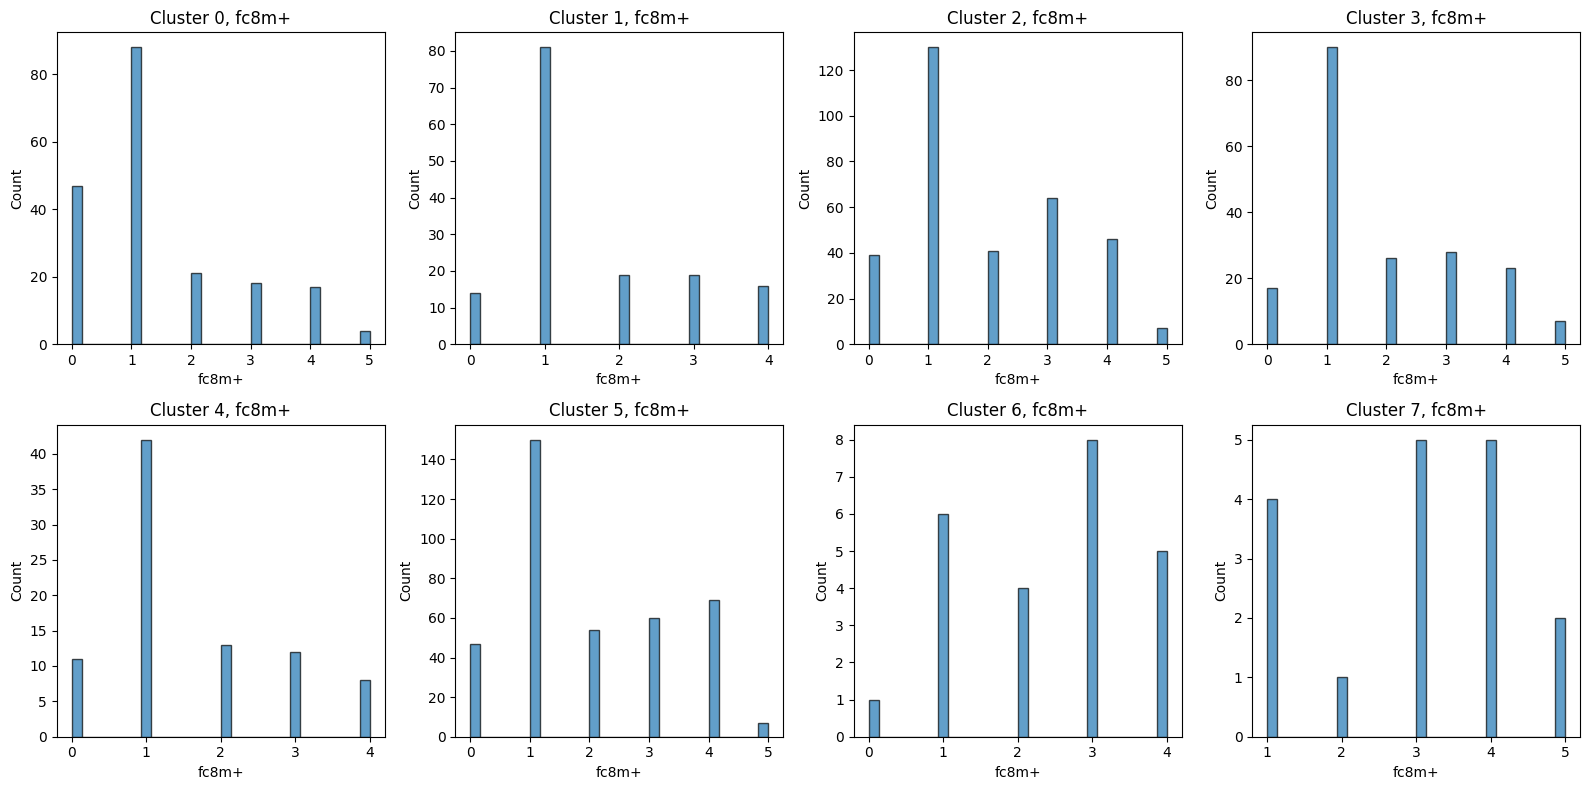

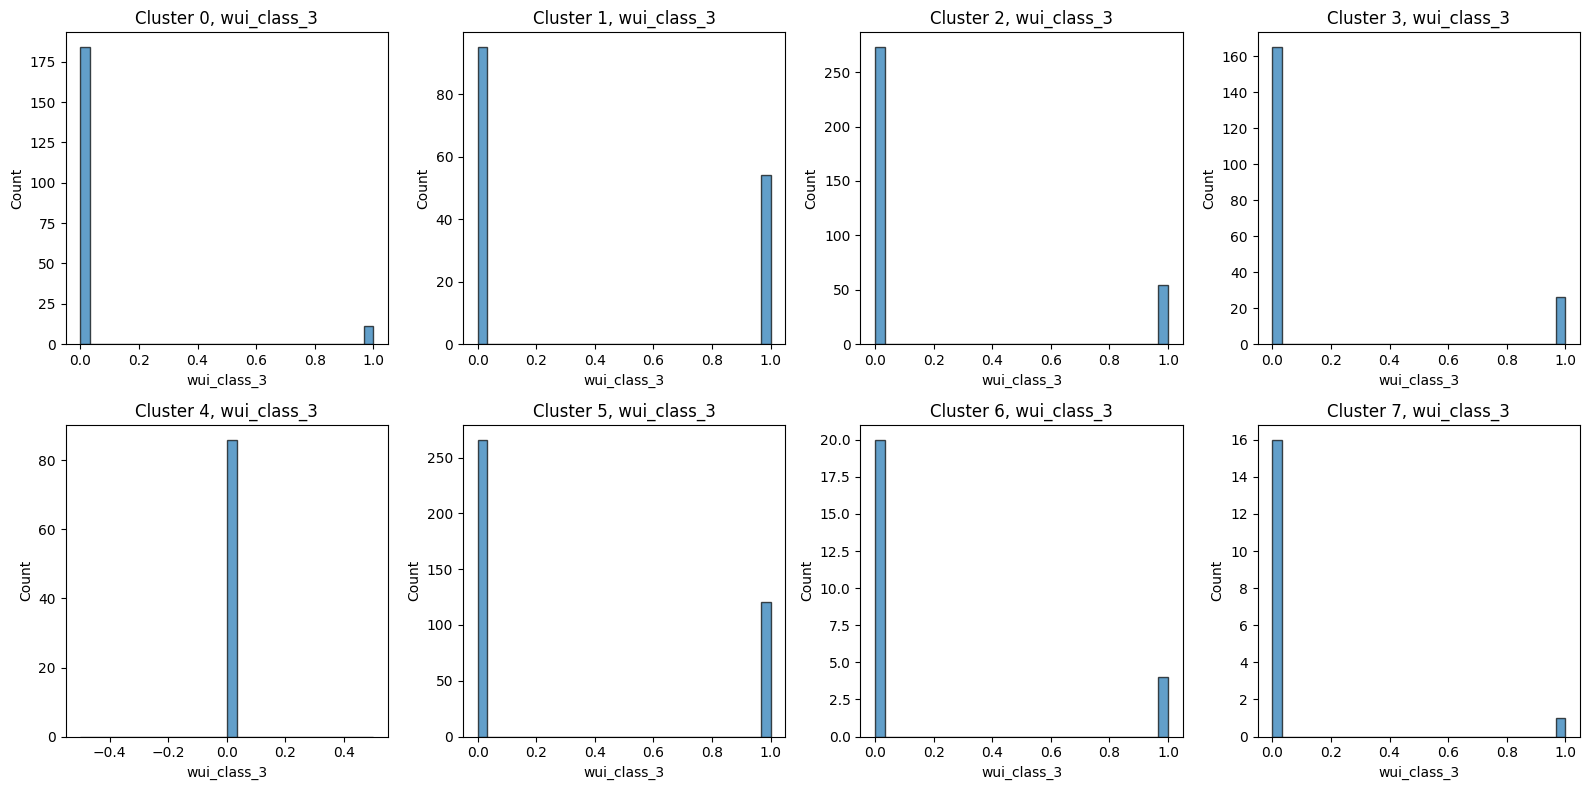

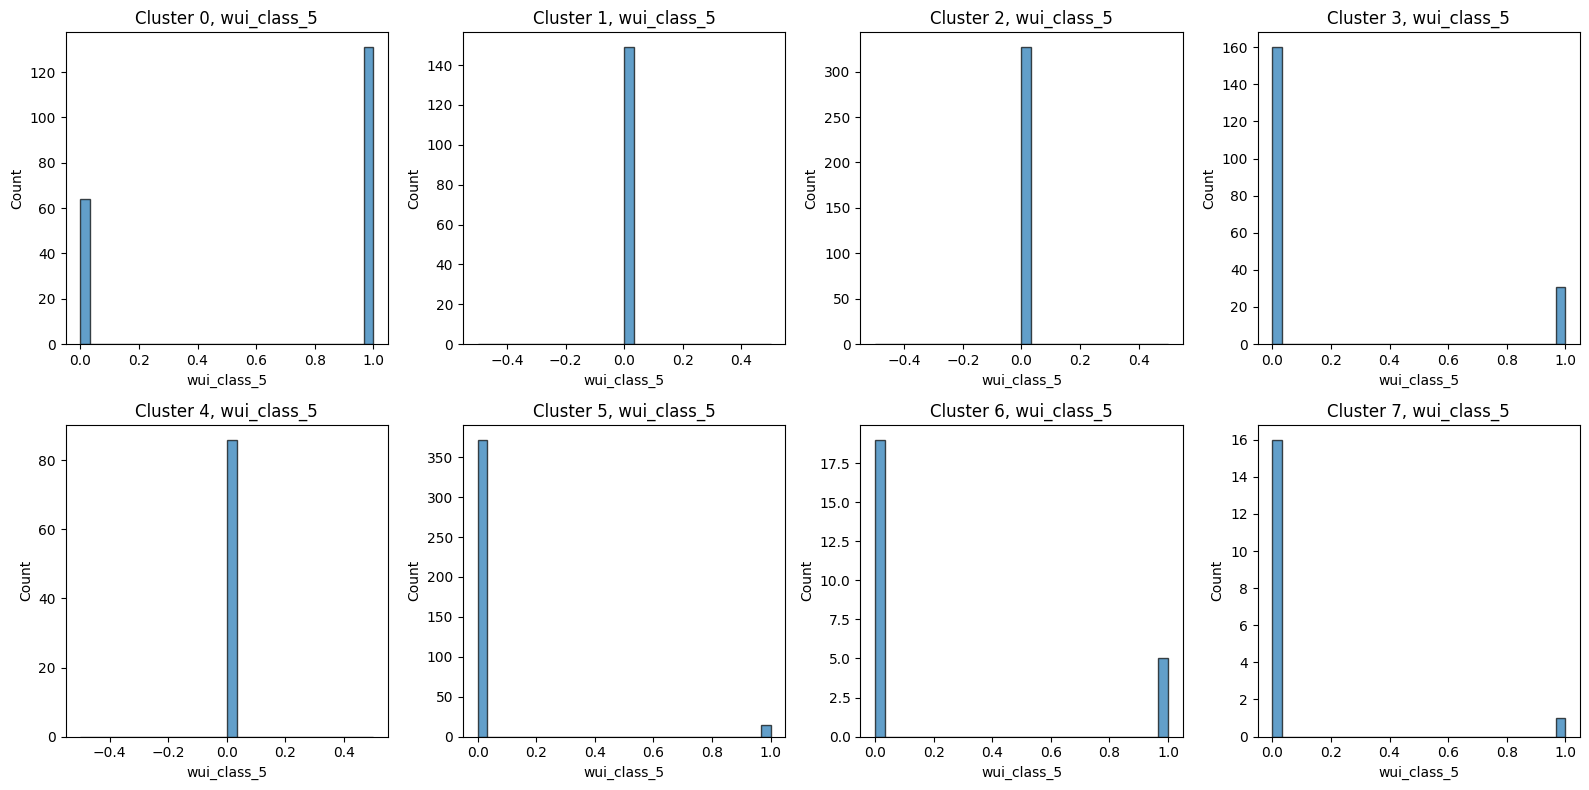

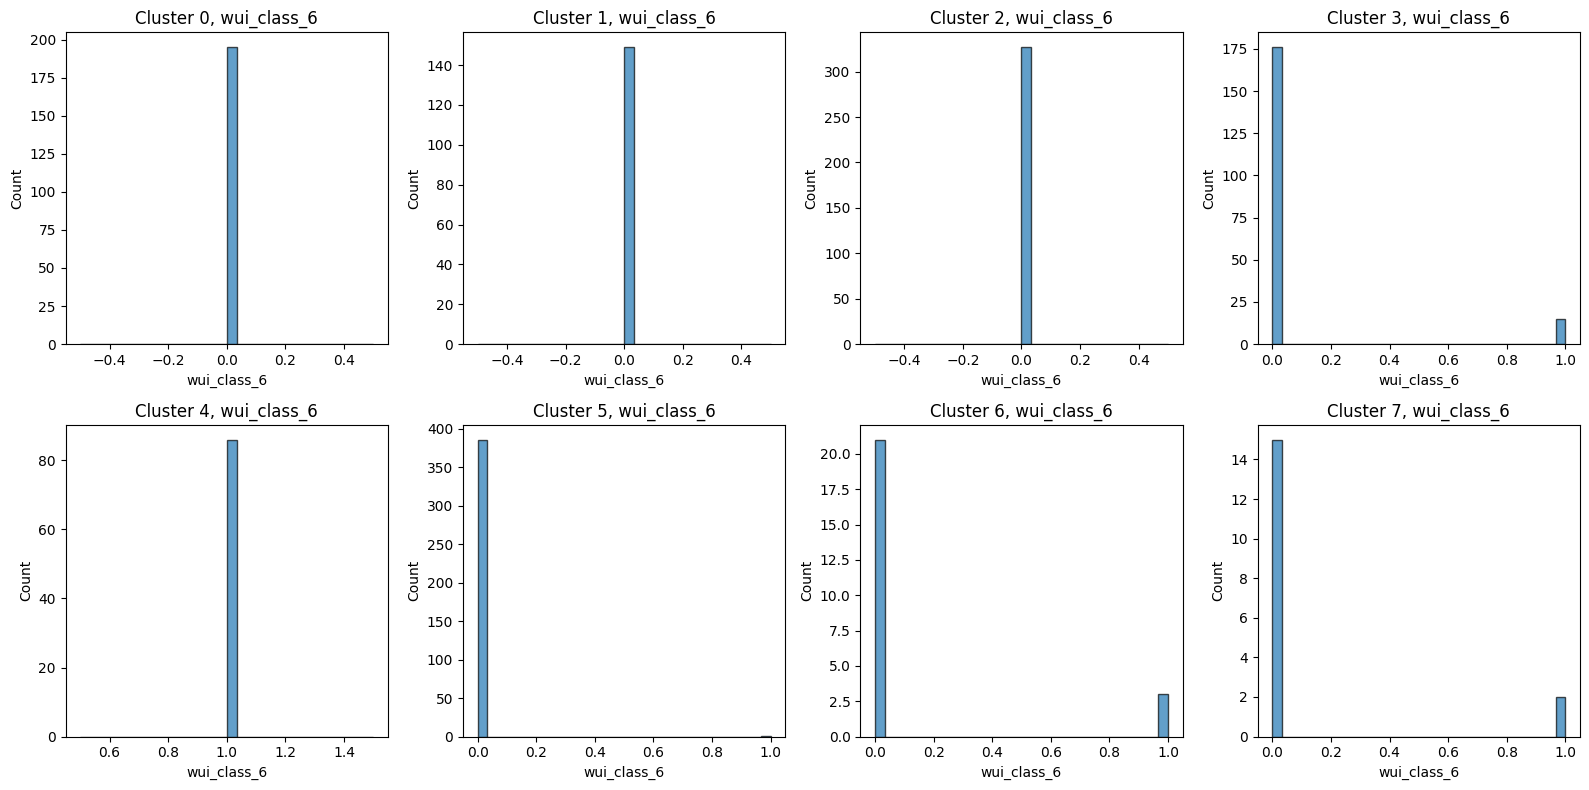

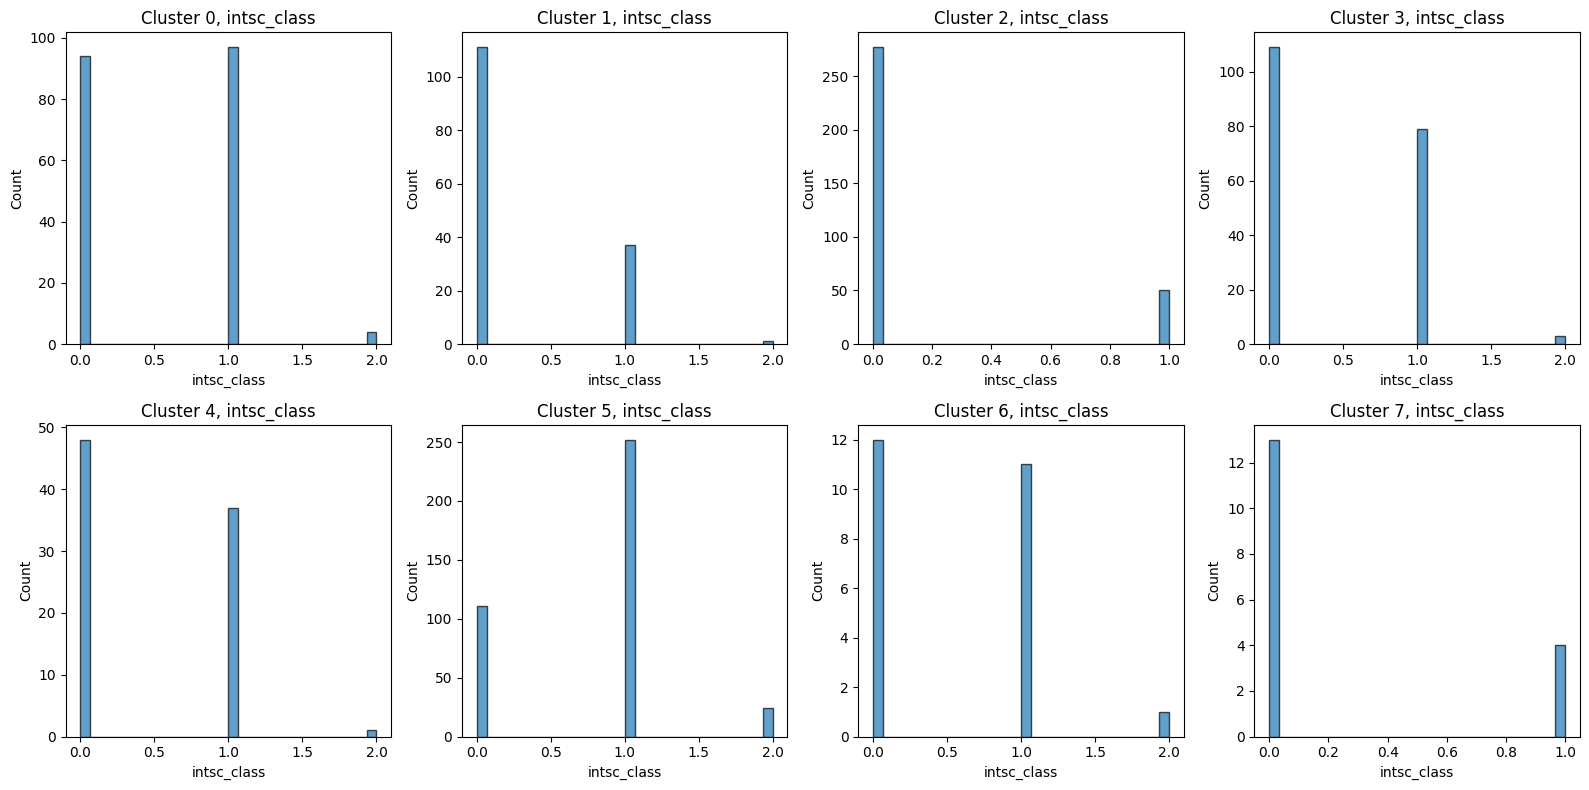

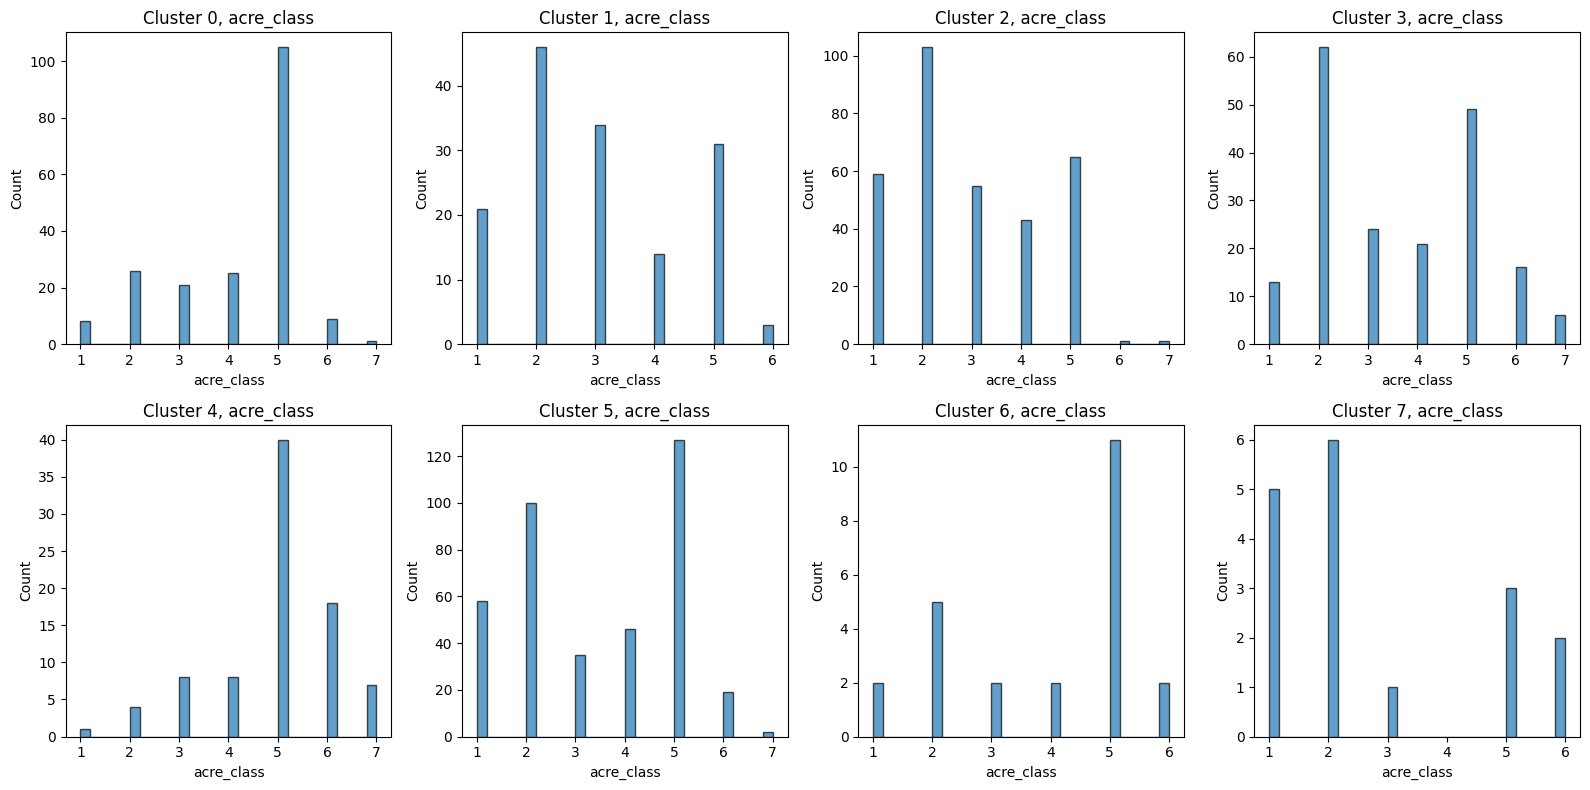

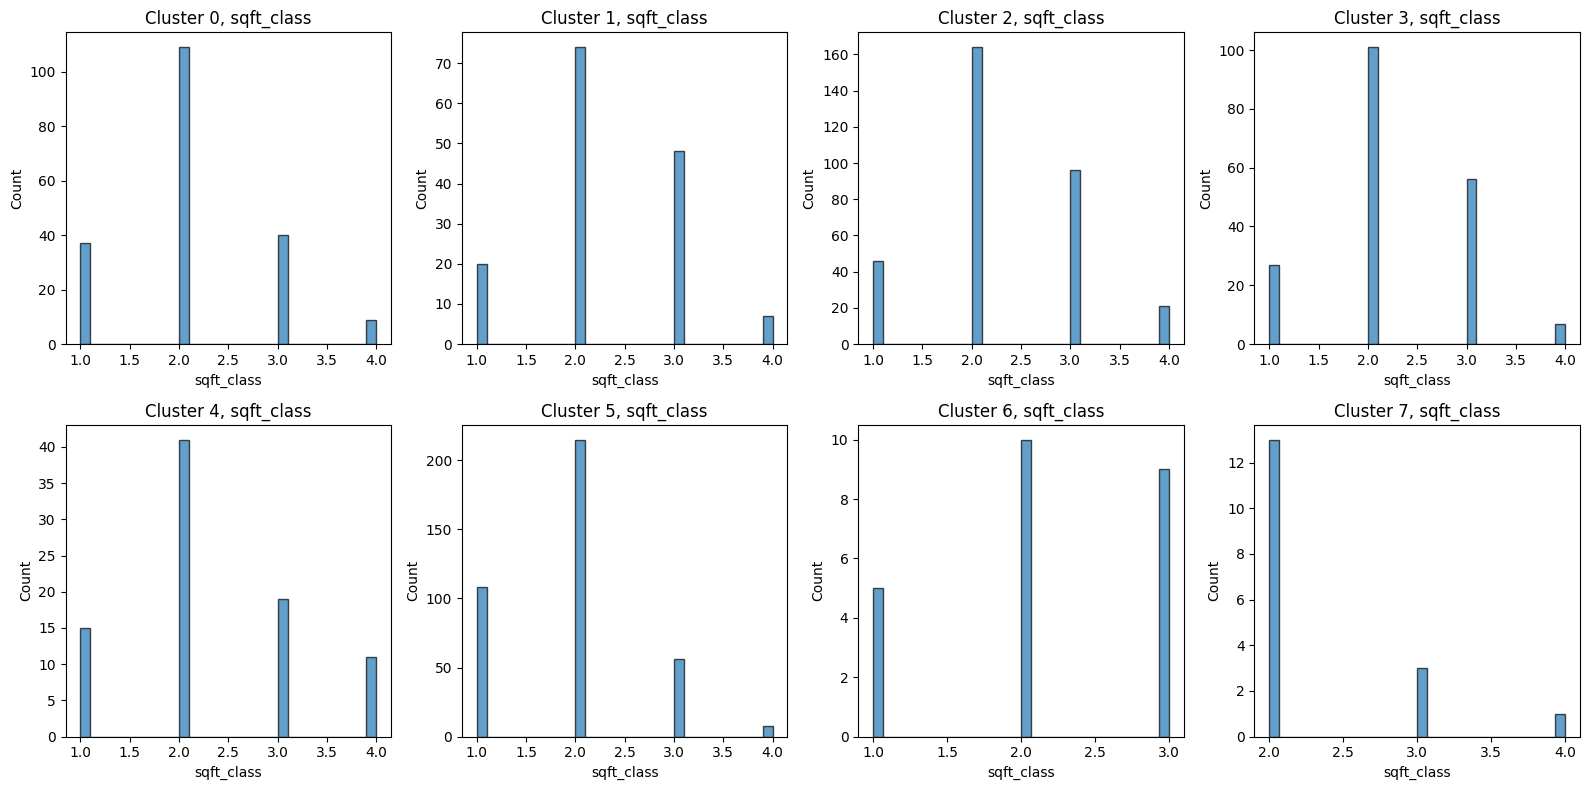

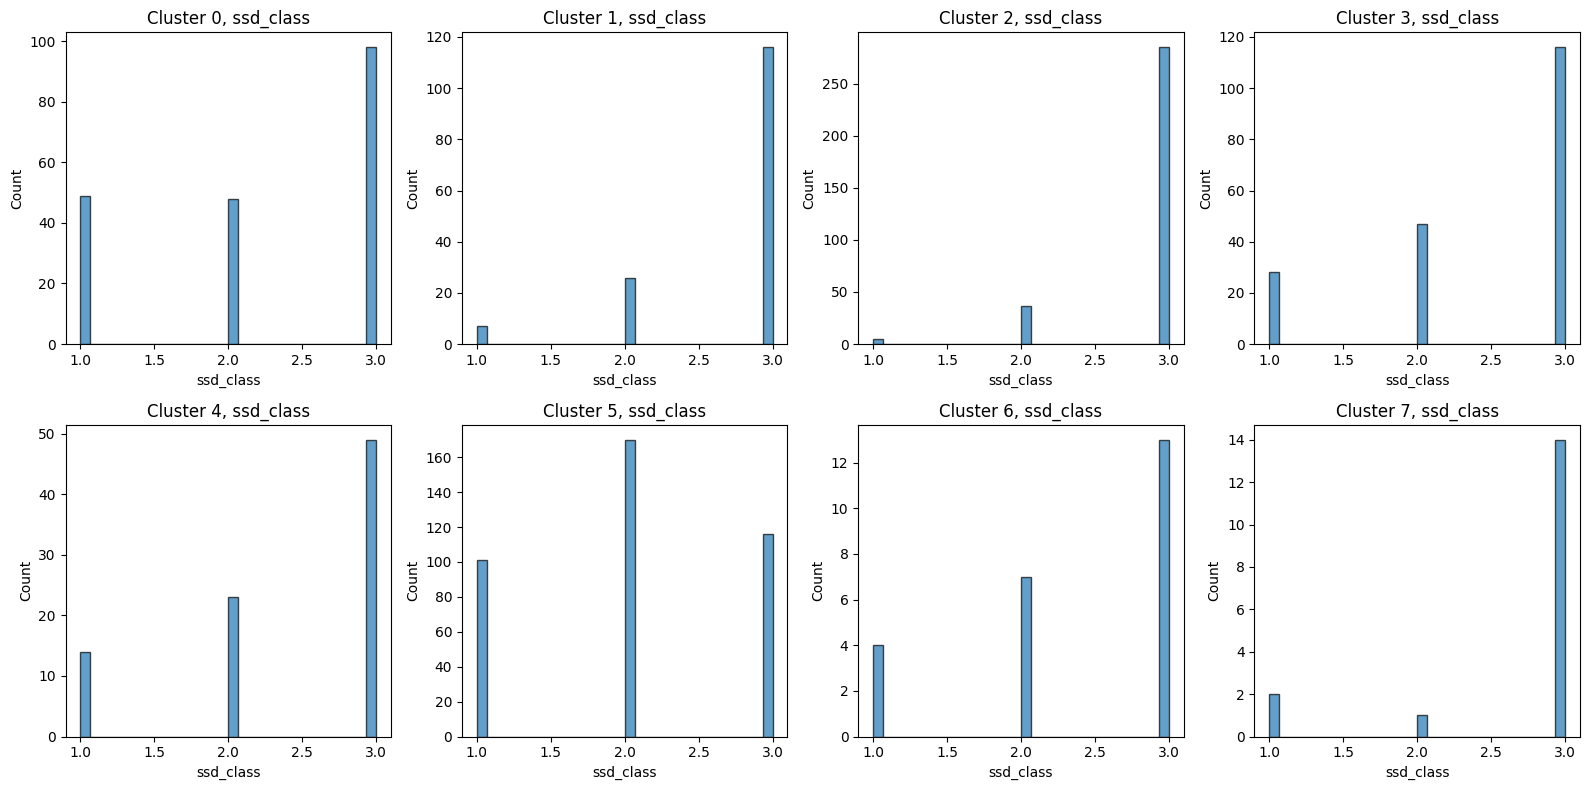

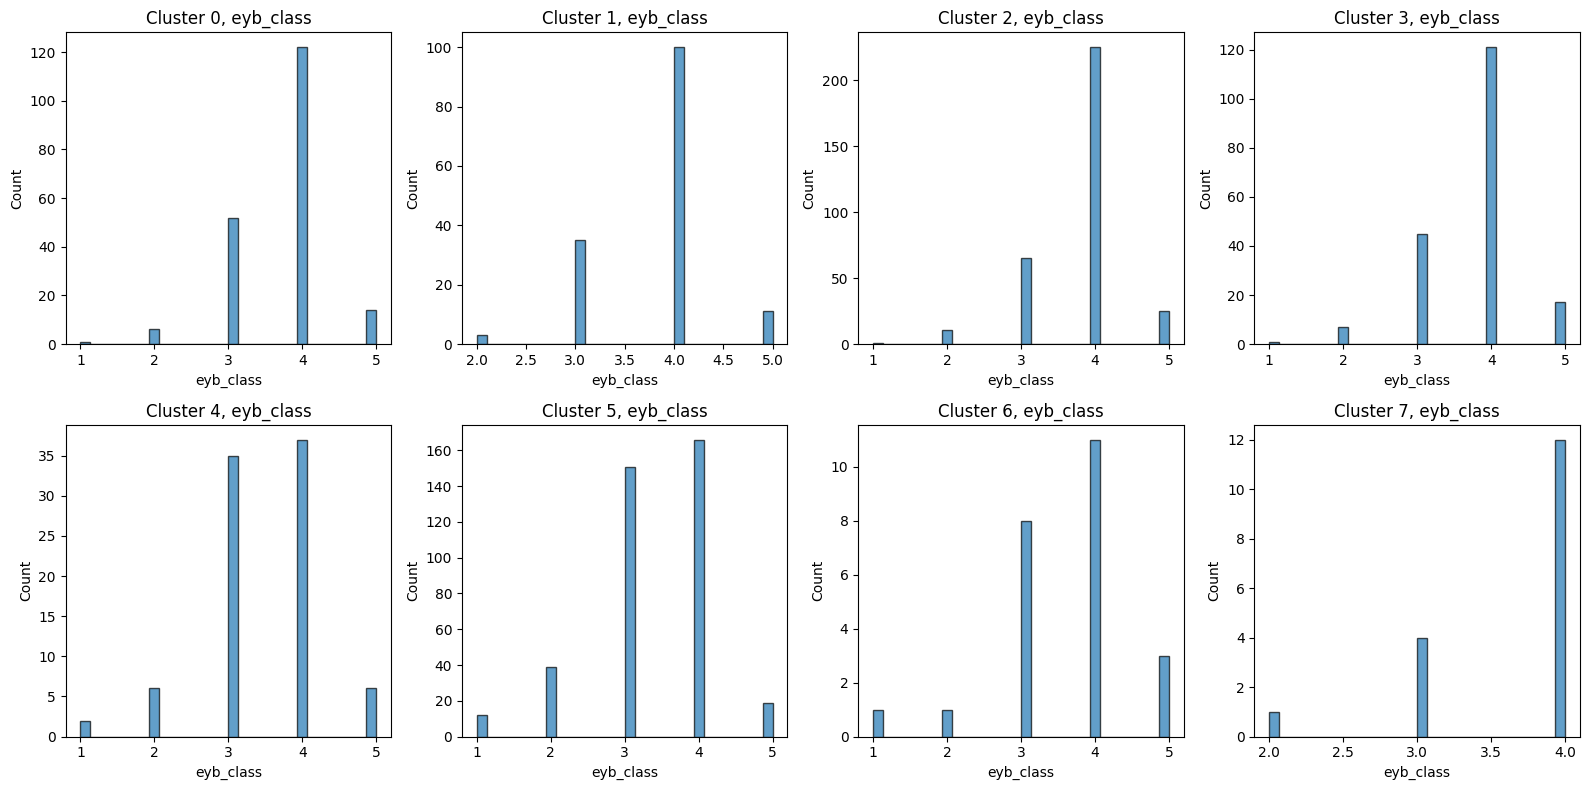

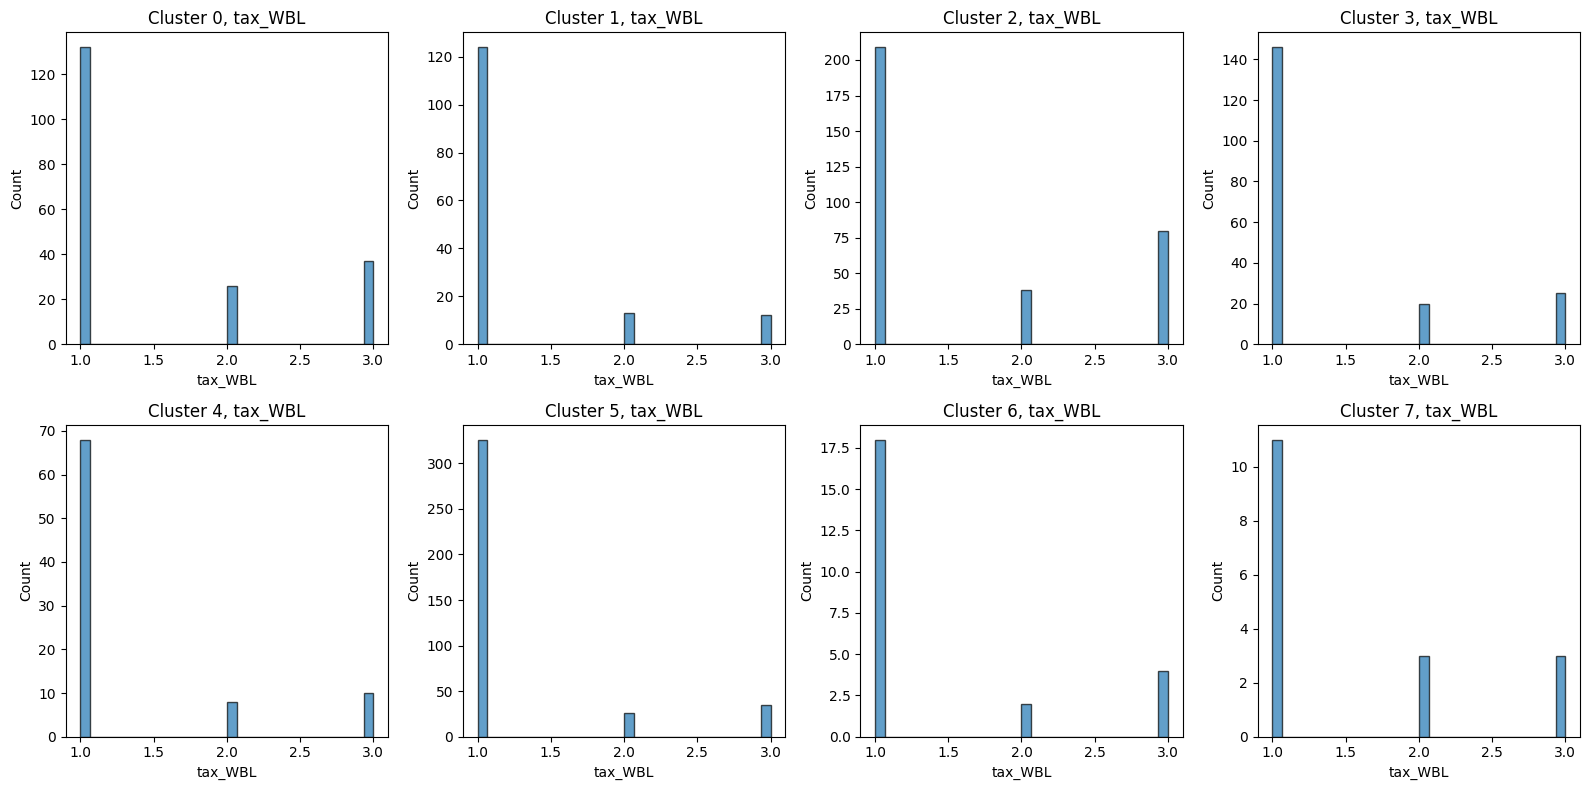

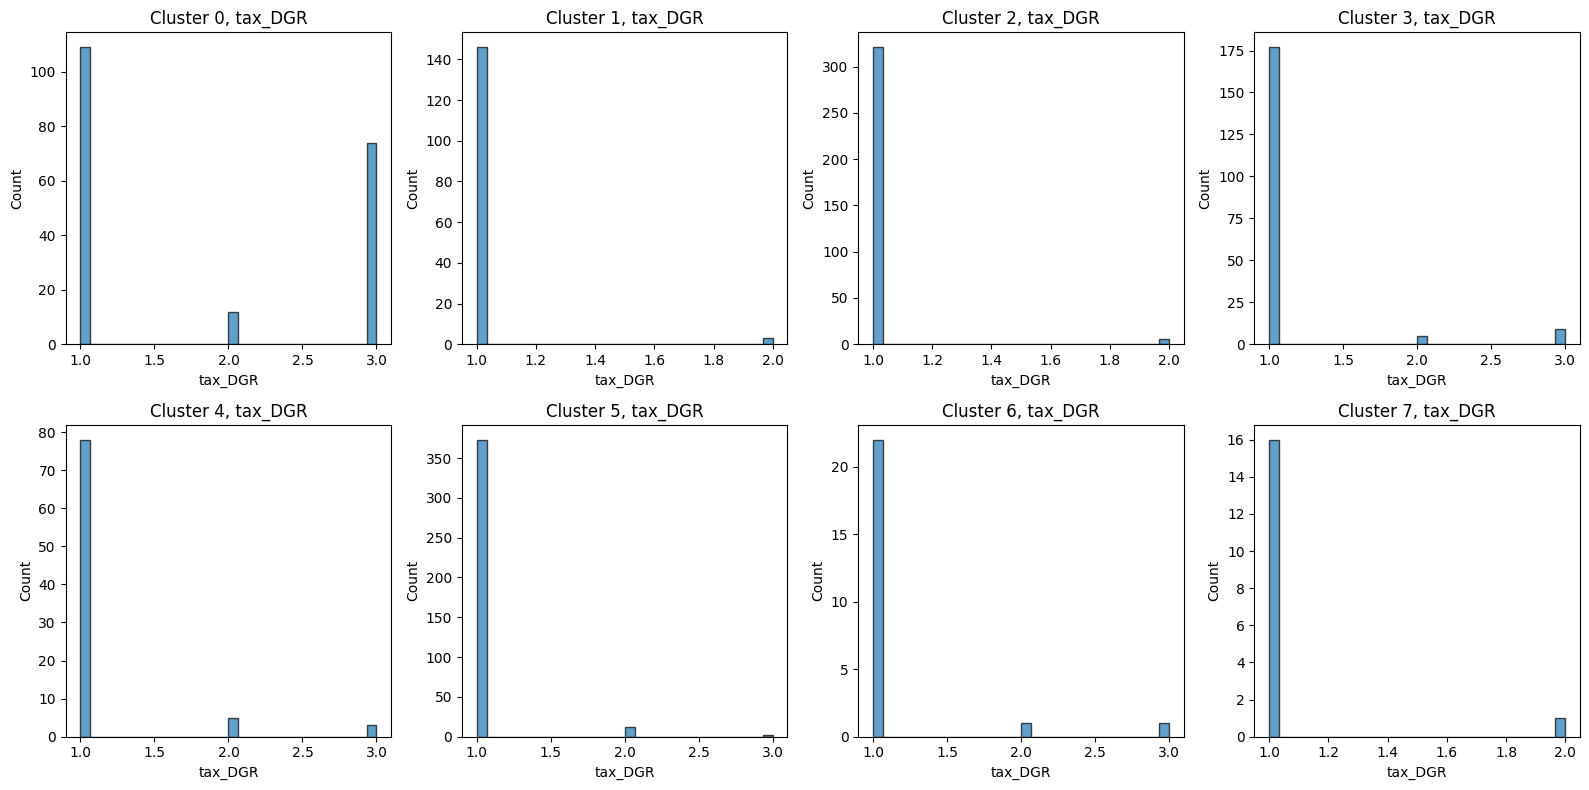

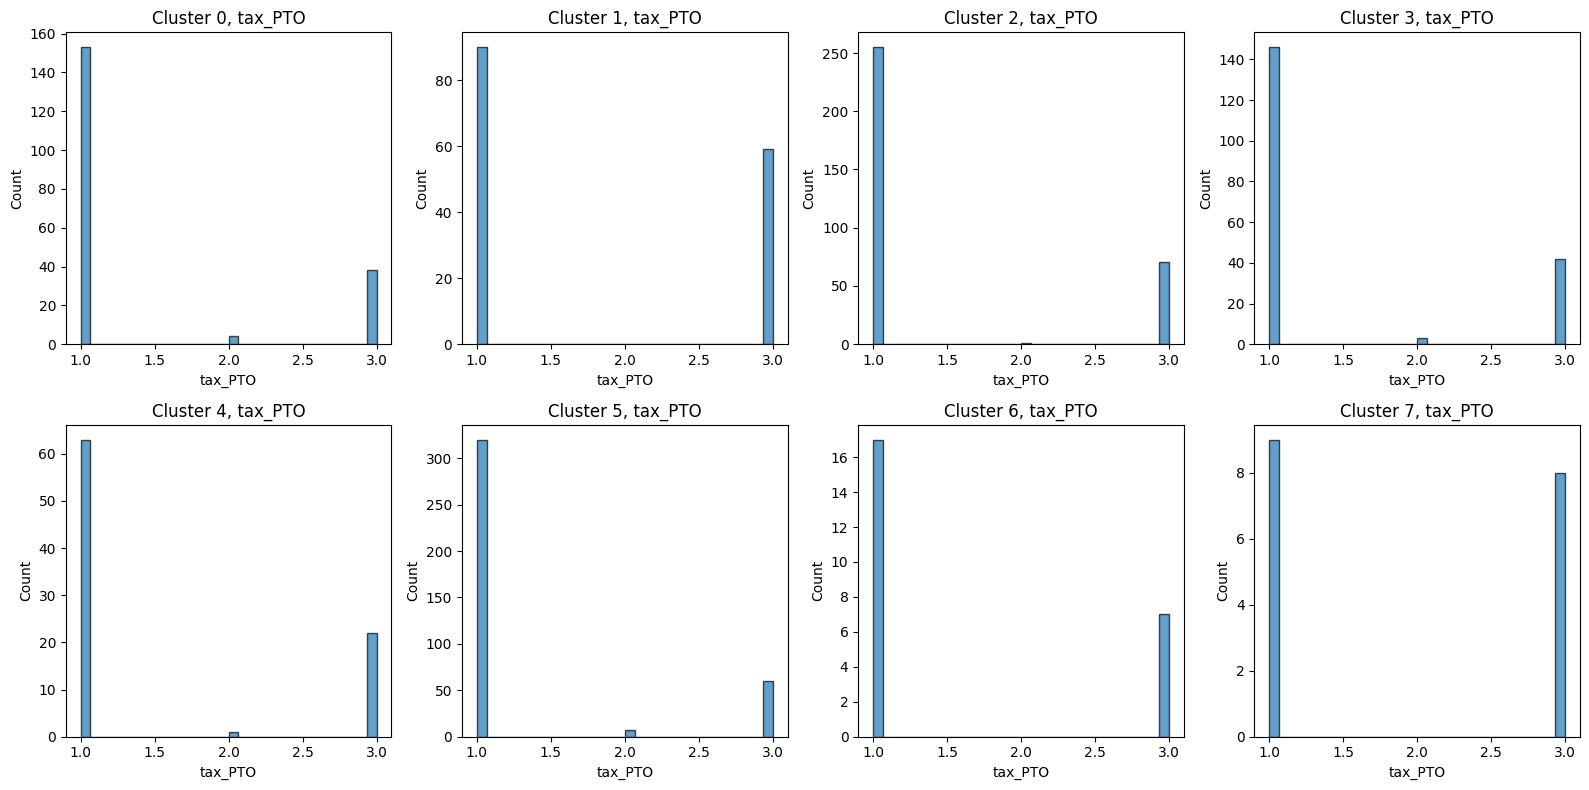

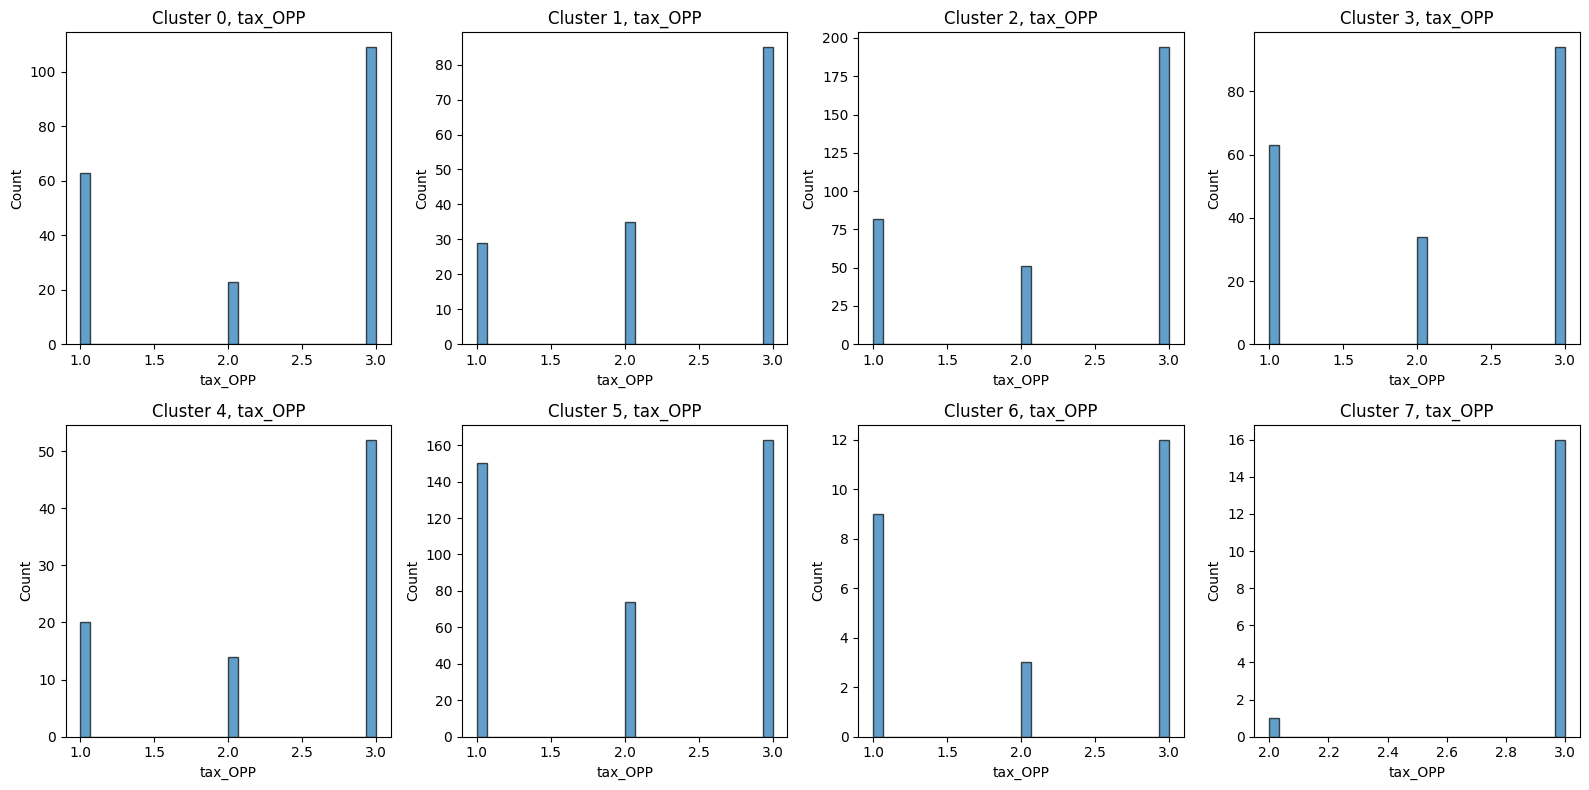

In [16]:
import matplotlib.pyplot as plt

# Define function for plotting clusters in 2x4 subplots by feature
def plot_feature_histograms(feature, spc):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2x4 layout
    axes = axes.flatten()  # Convert to 1D array for easy indexing
    
    for i, df in enumerate(spc):
        axes[i].hist(df[feature], bins=30, alpha=0.7, edgecolor="black")
        axes[i].set_title(f"Cluster {i}, {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

# Plot all features for all clusters
for feature in c_cols:
    plot_feature_histograms(feature, spc)


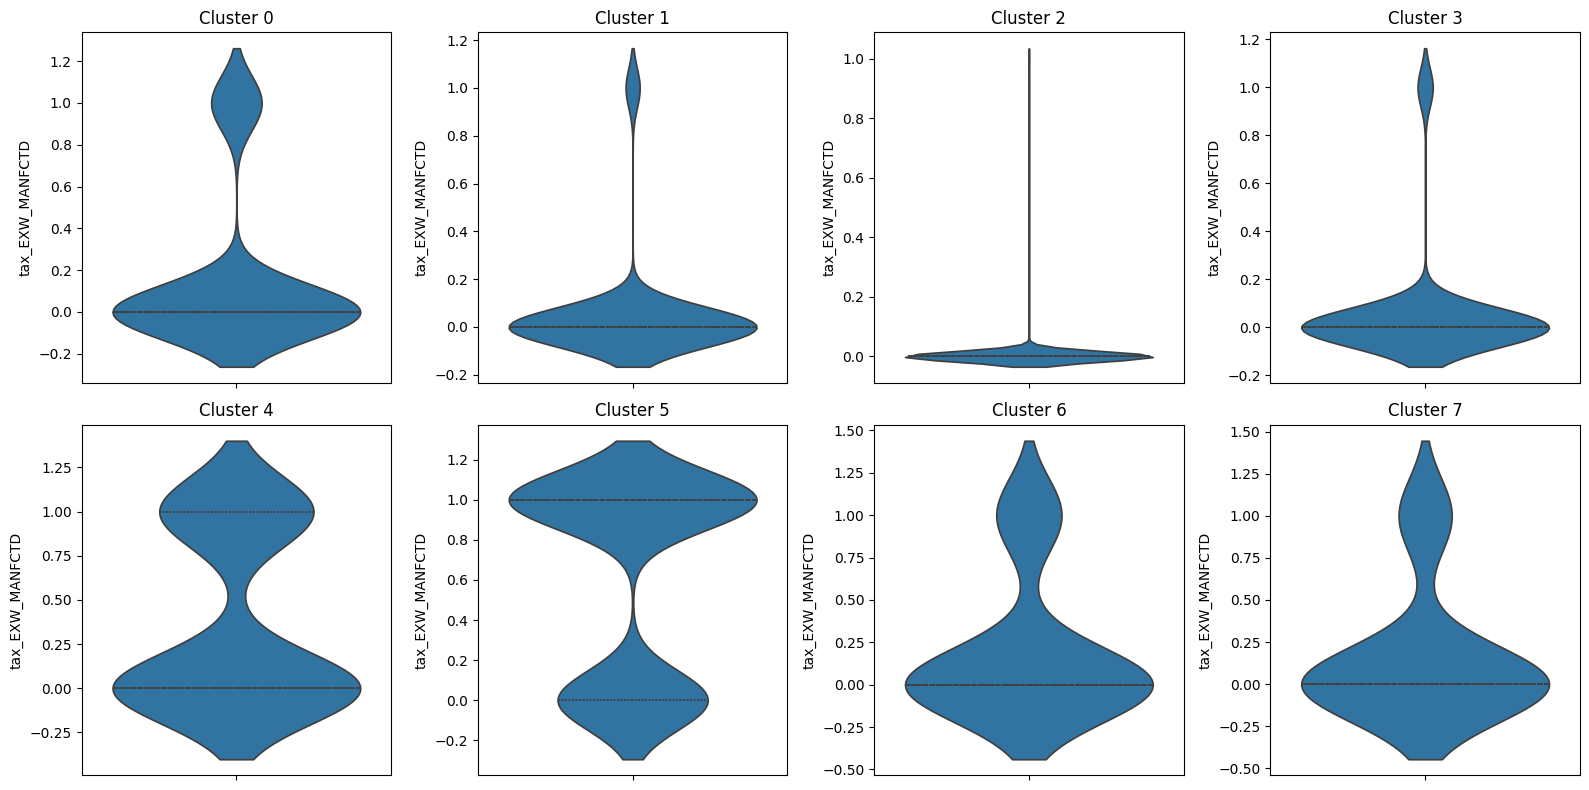

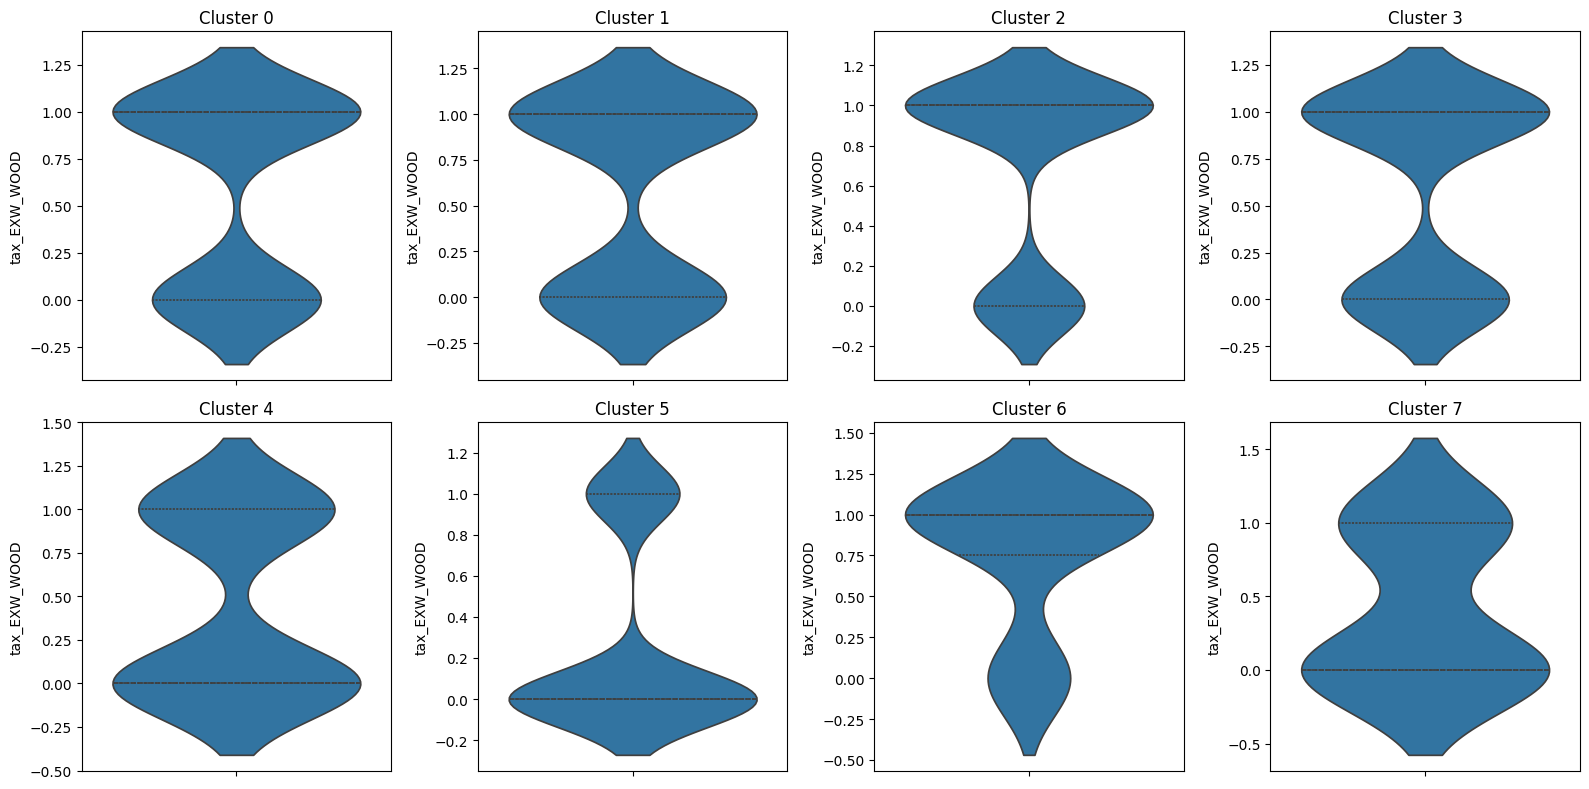

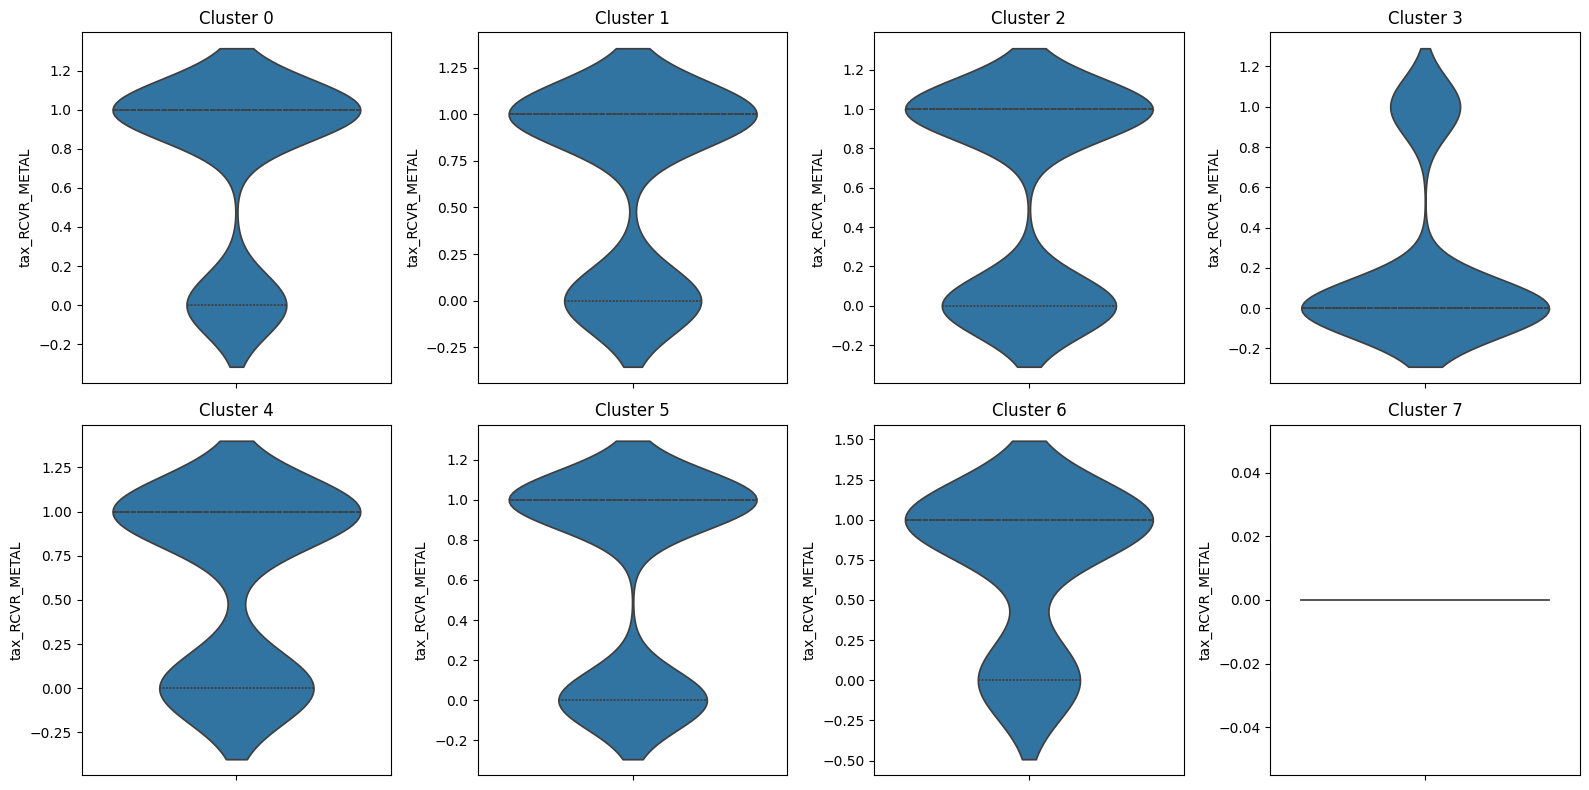

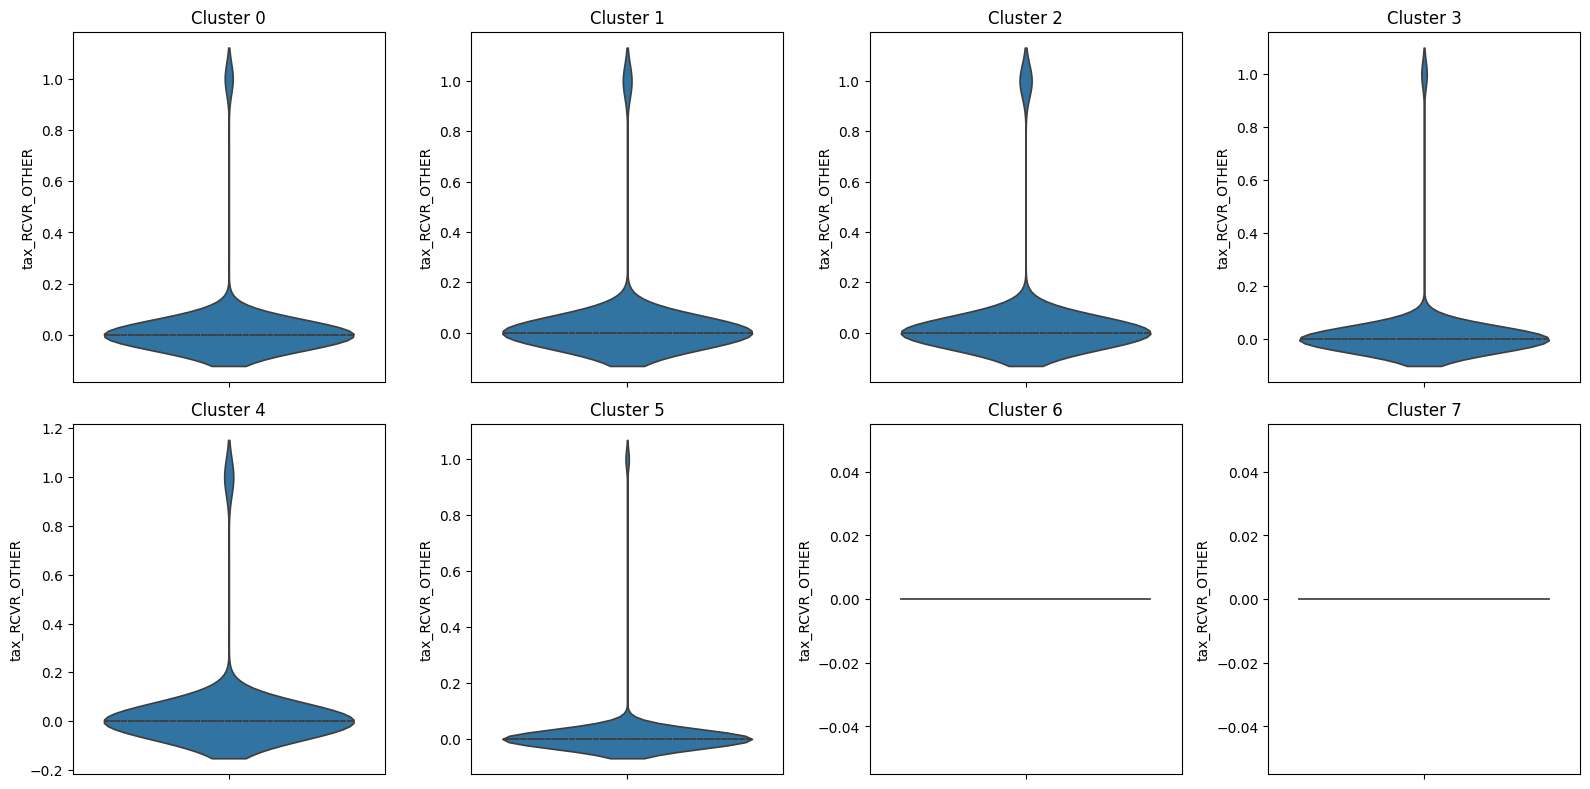

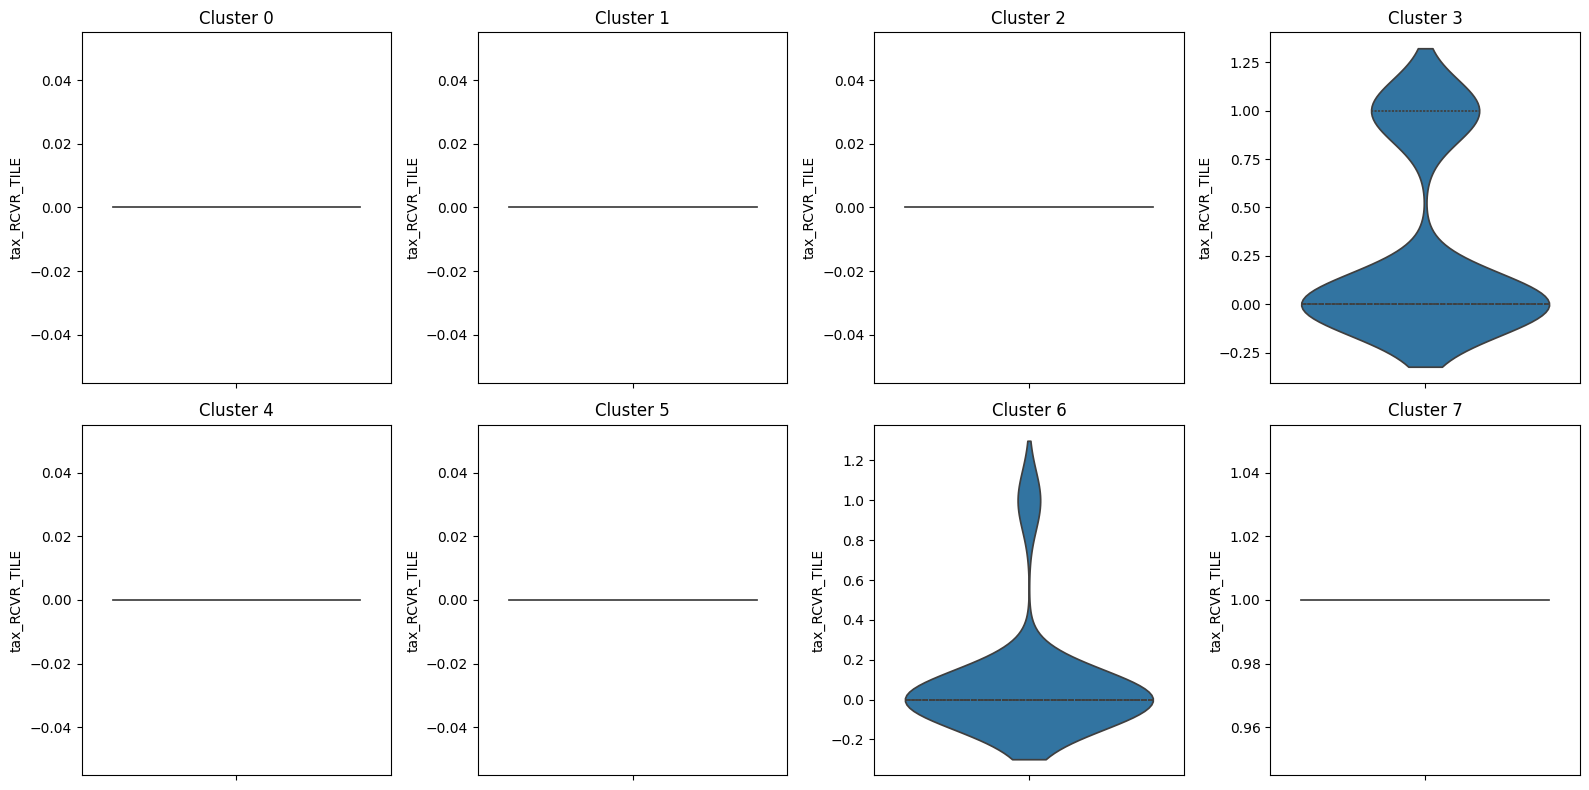

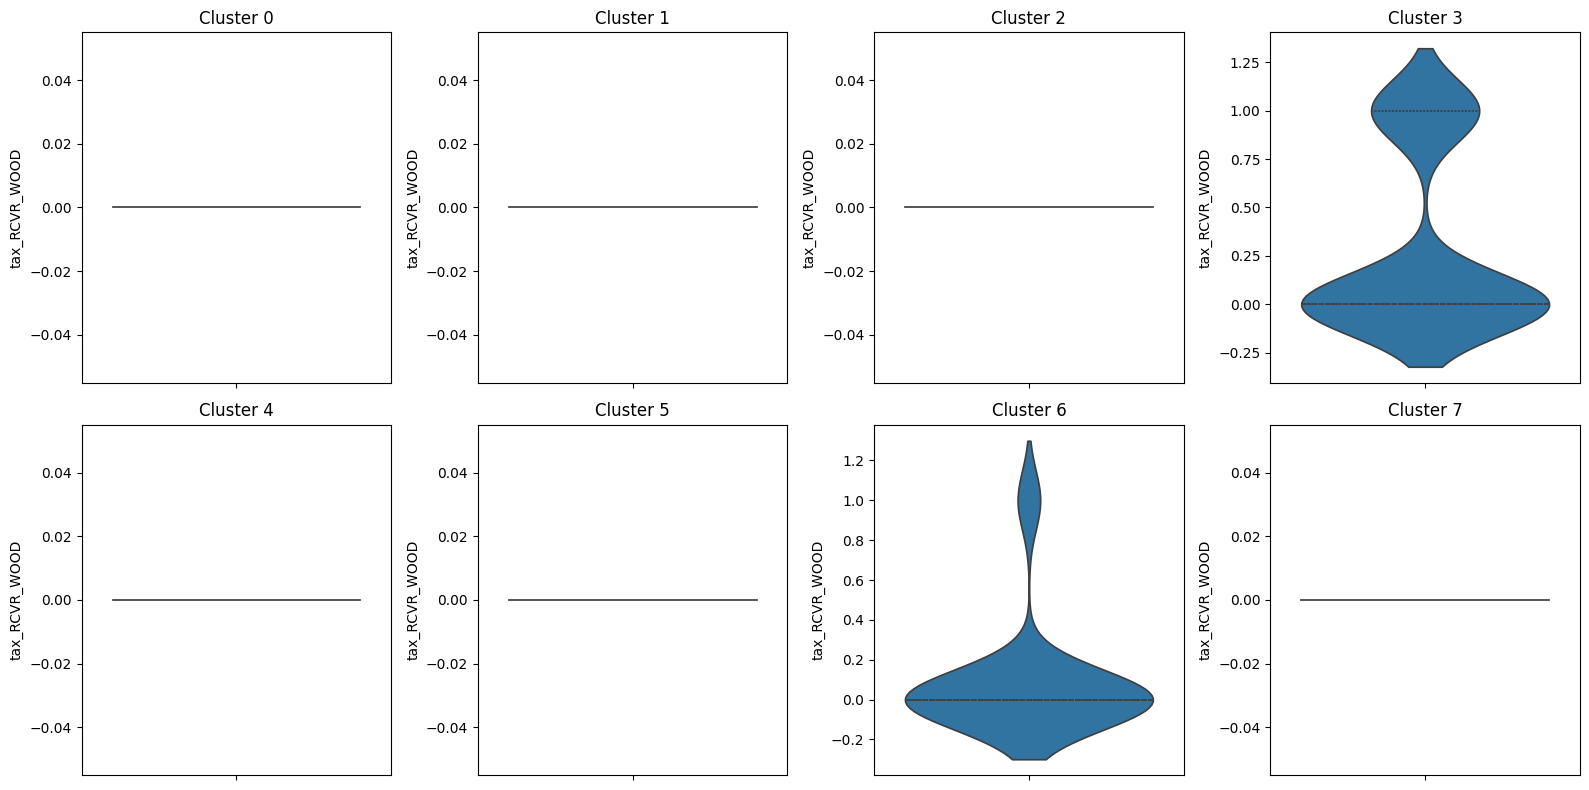

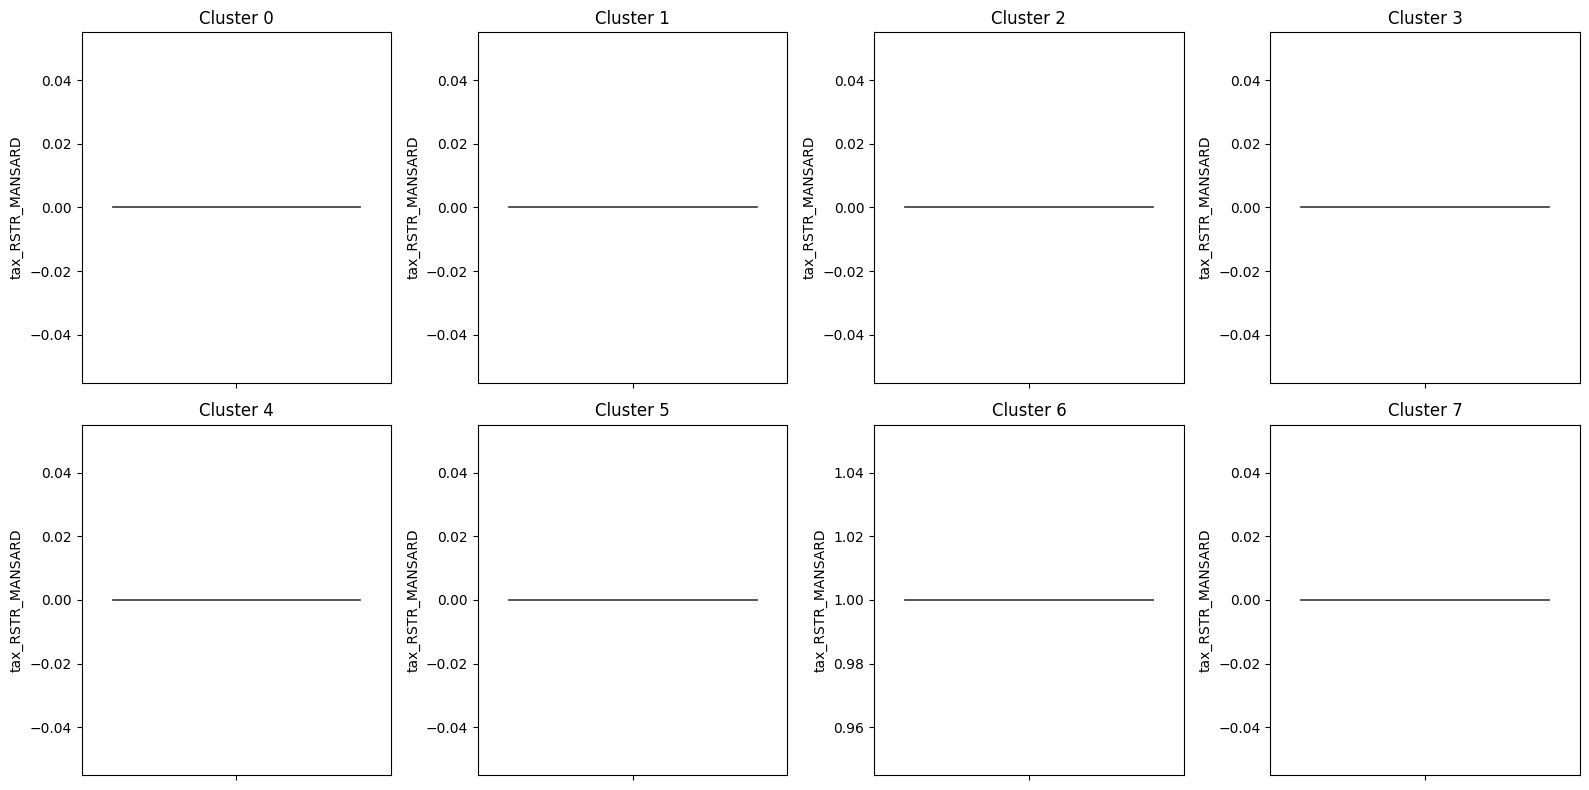

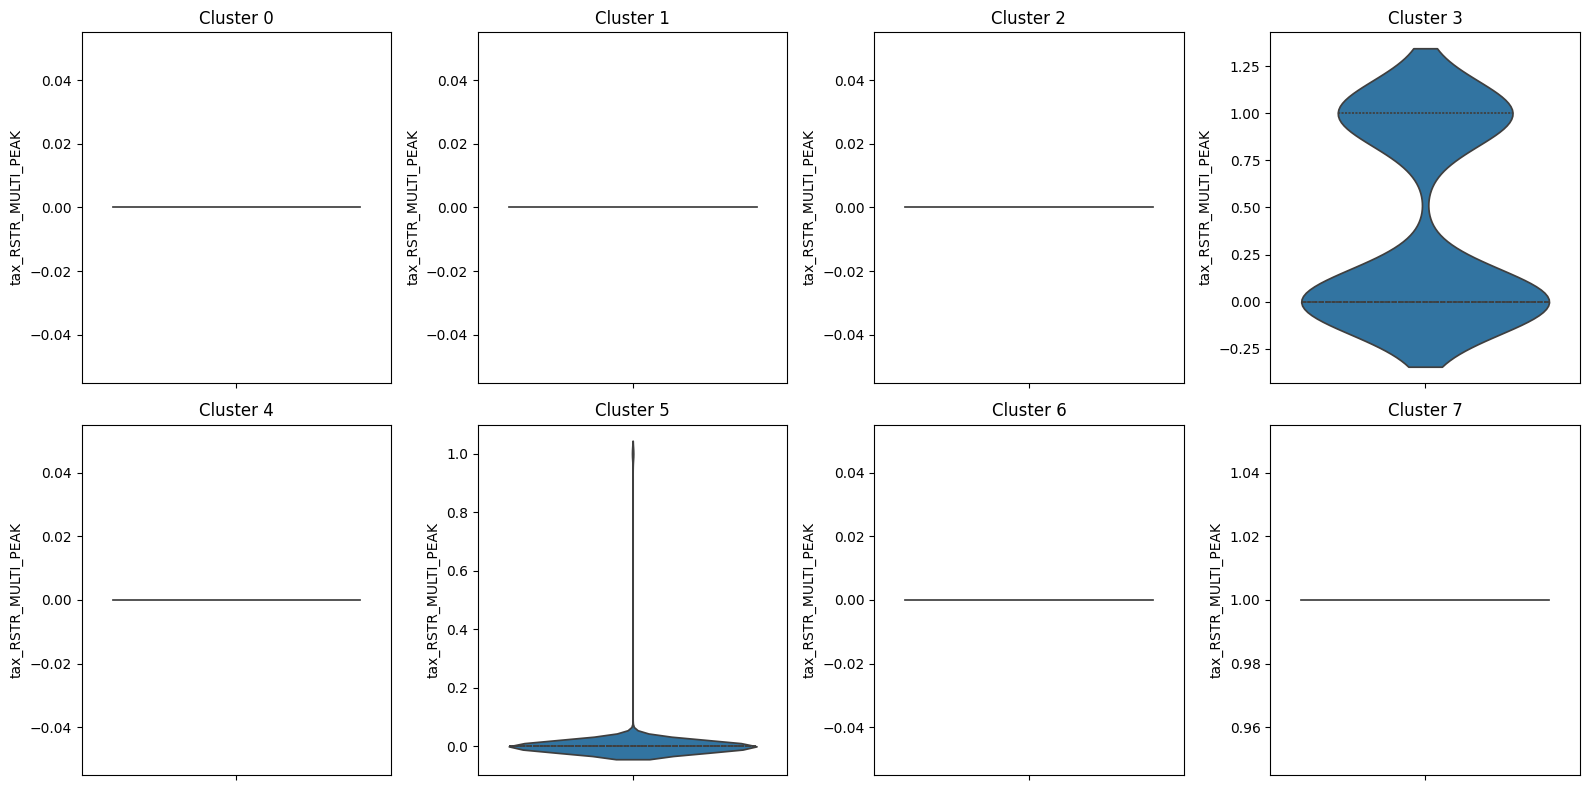

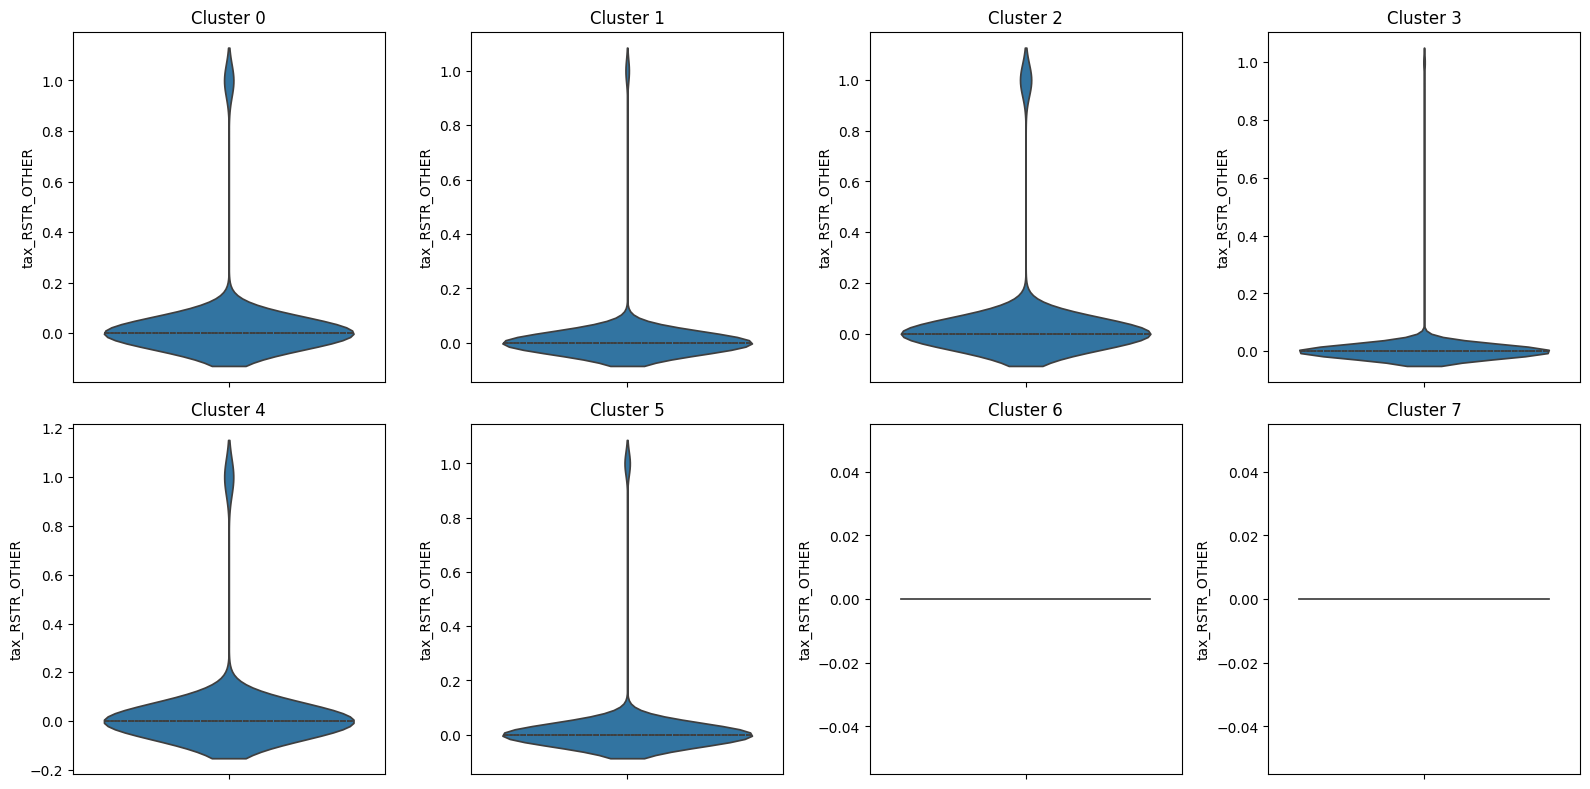

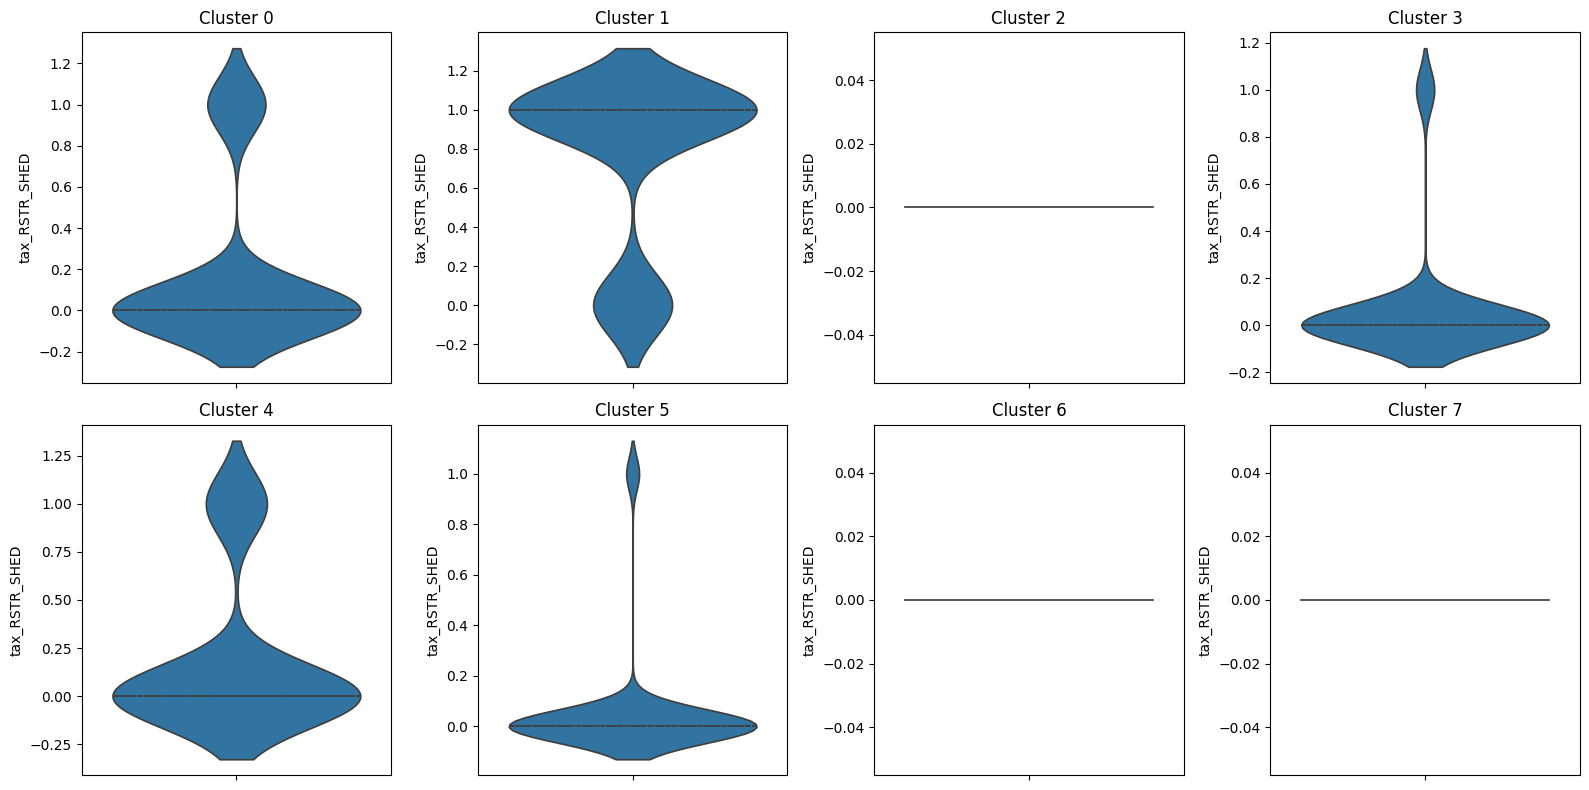

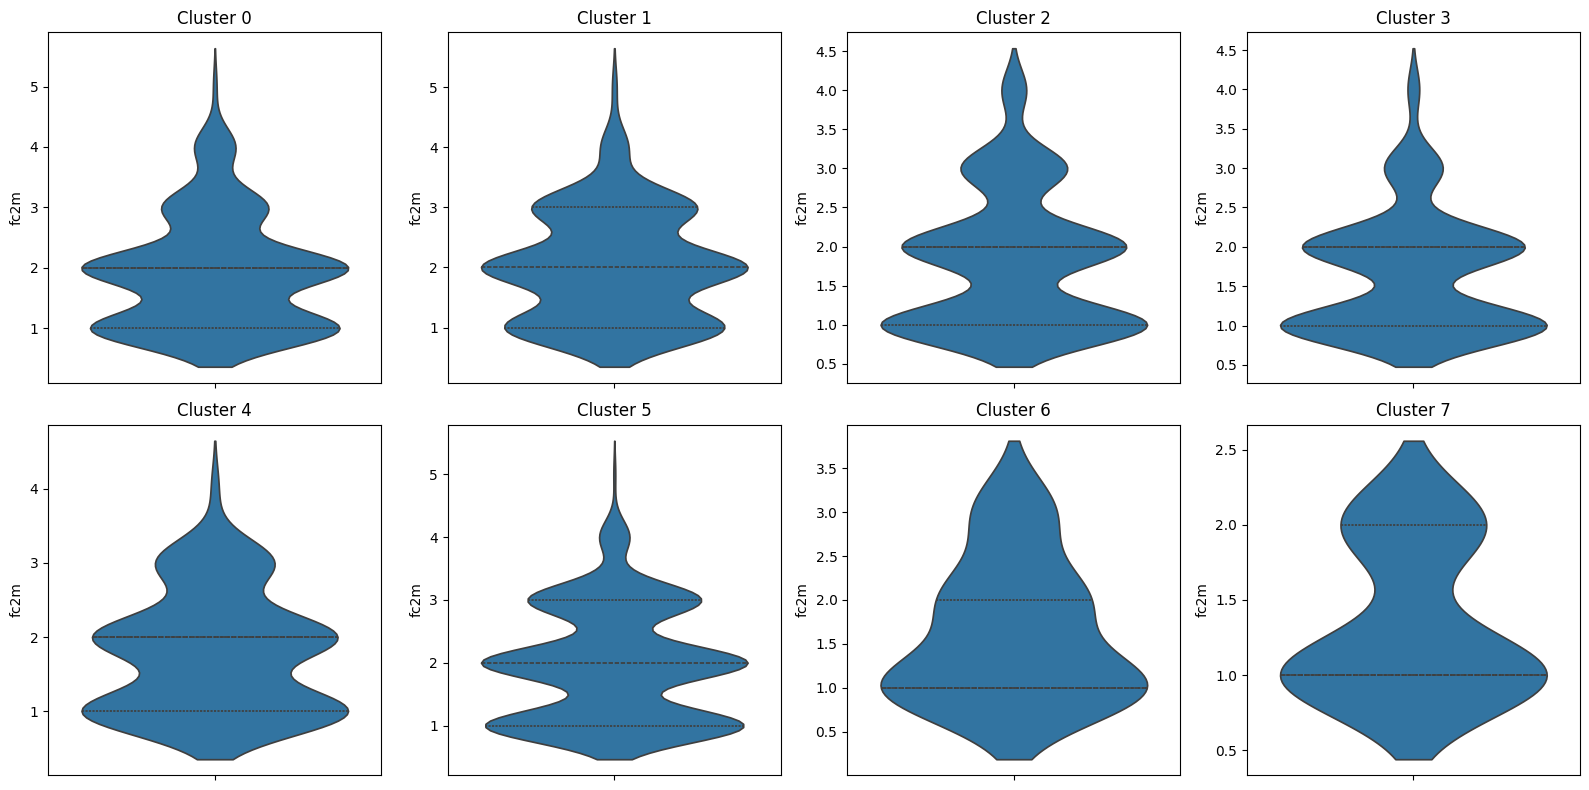

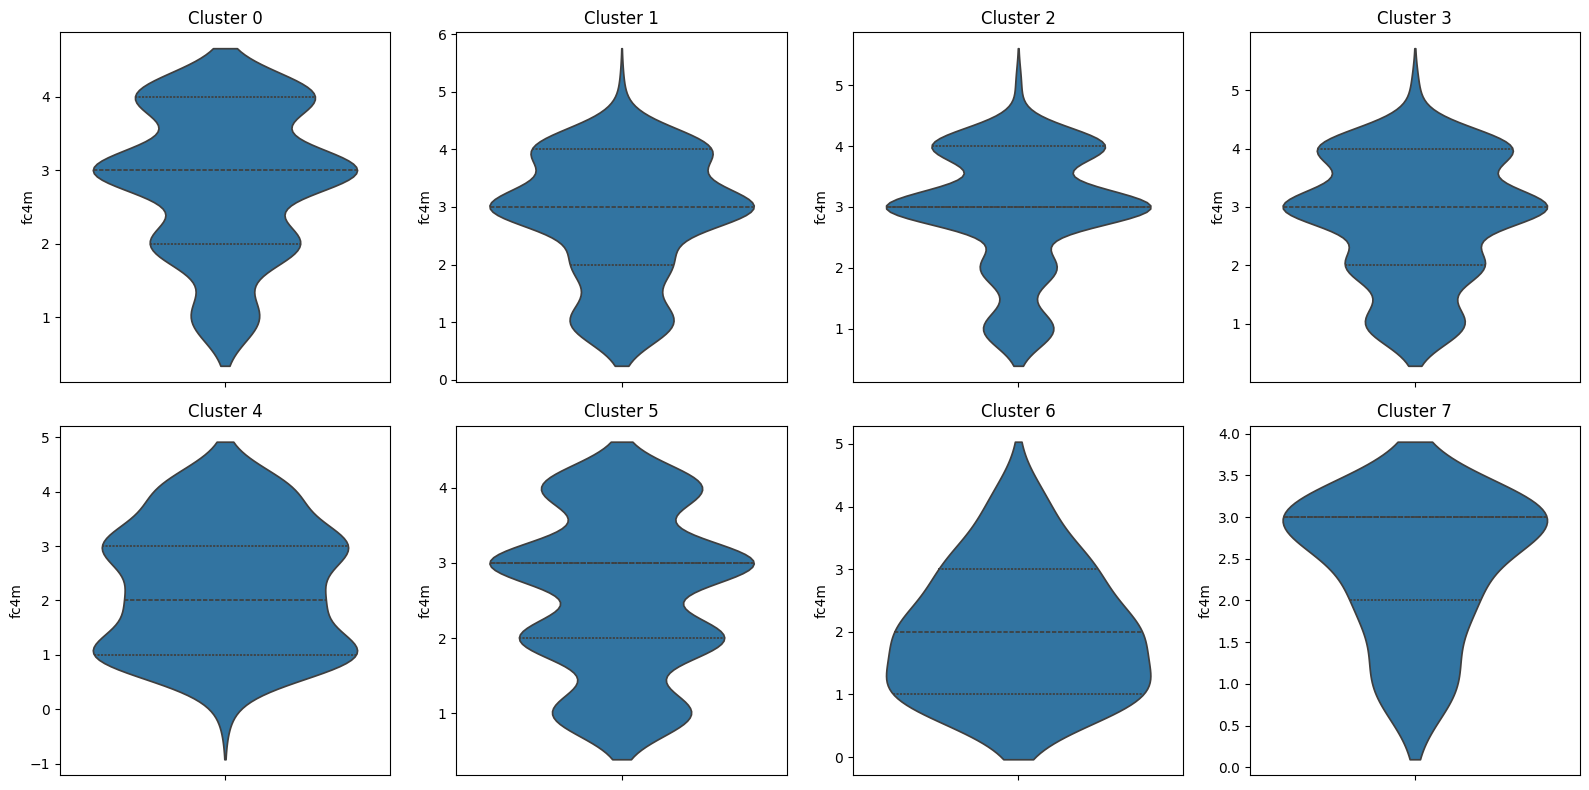

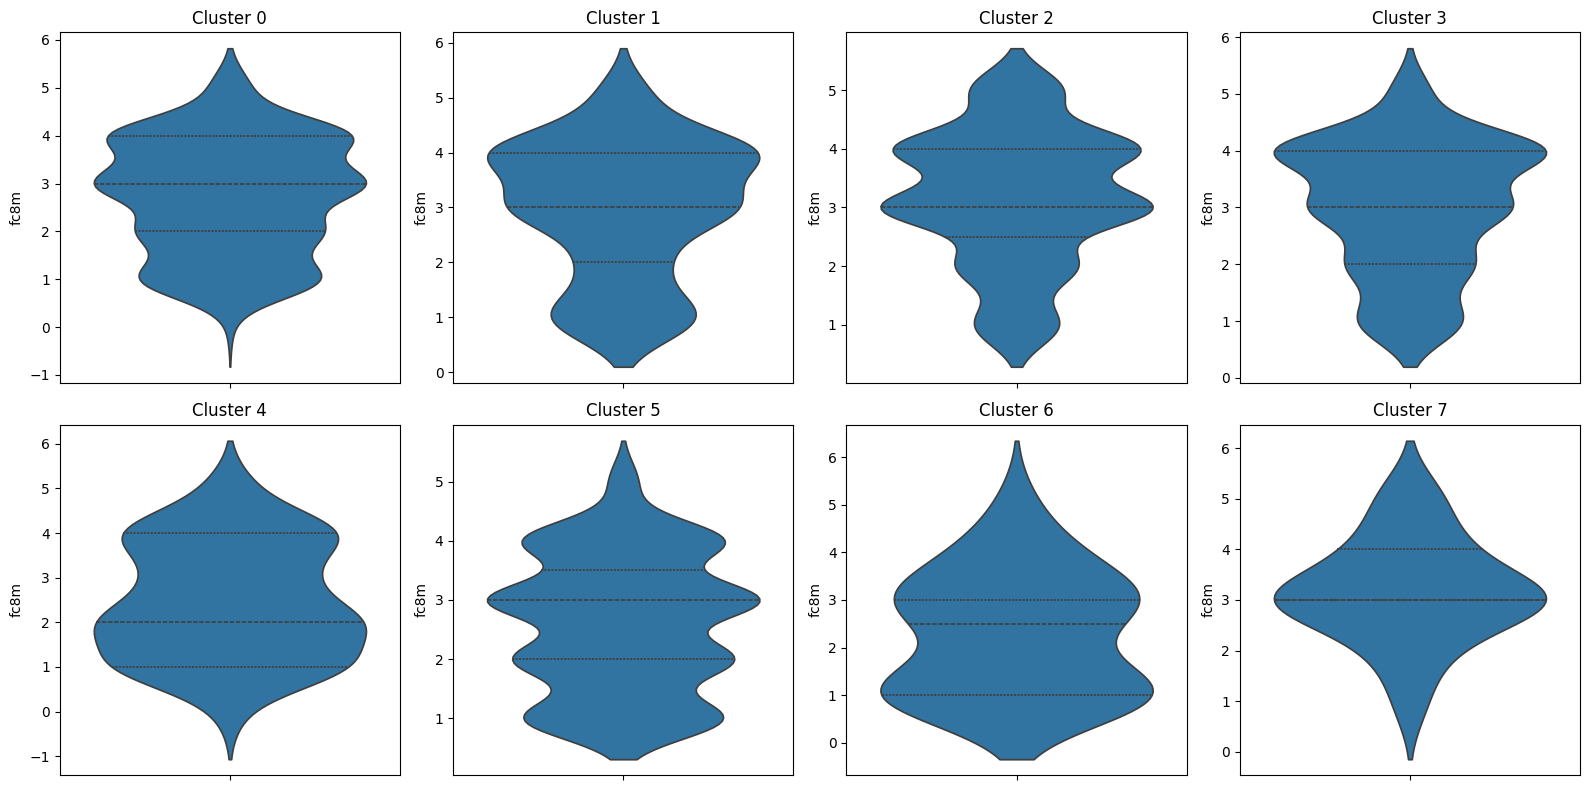

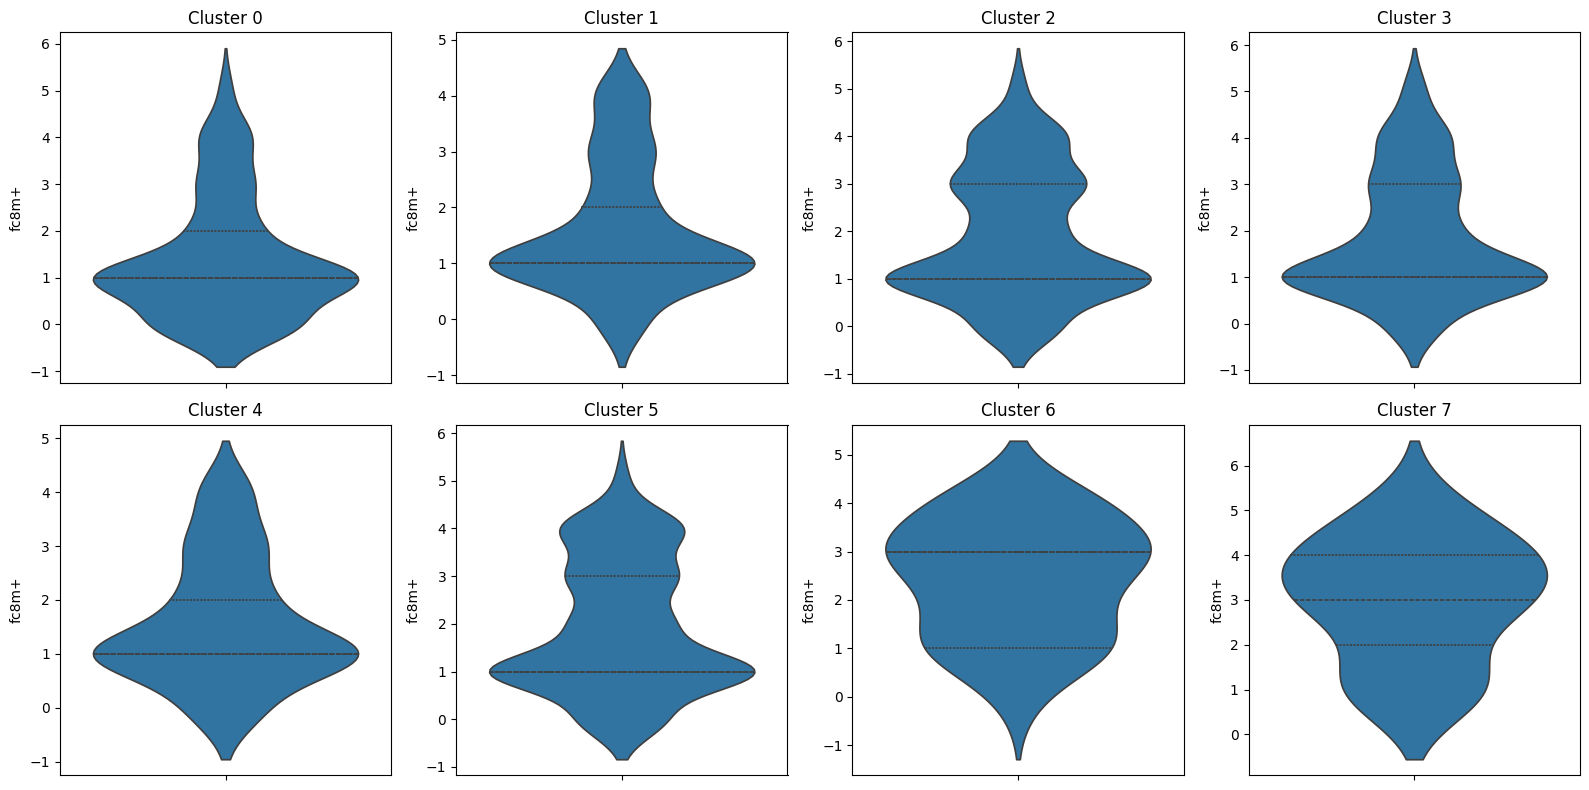

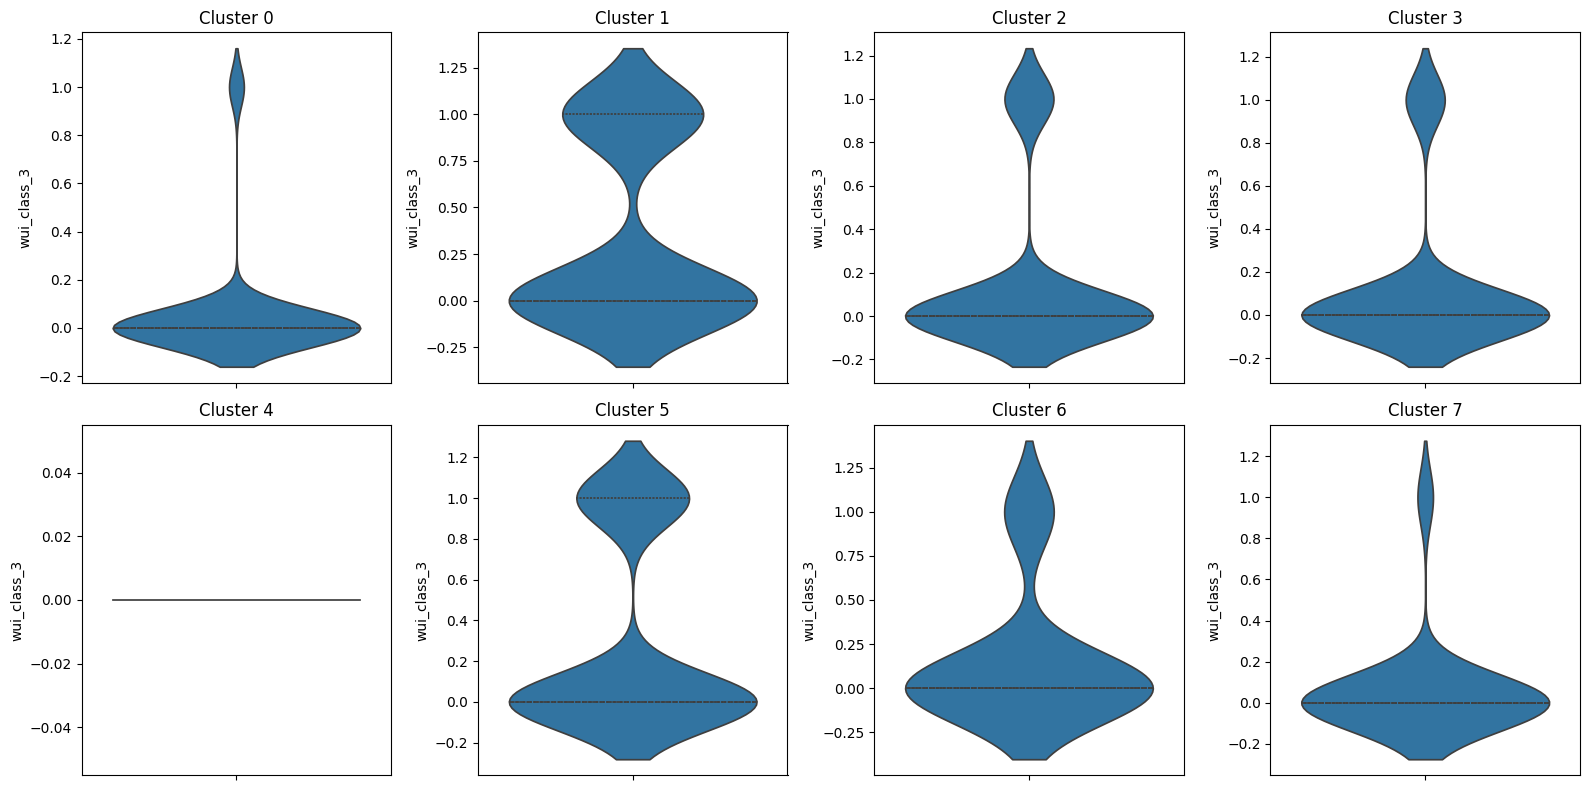

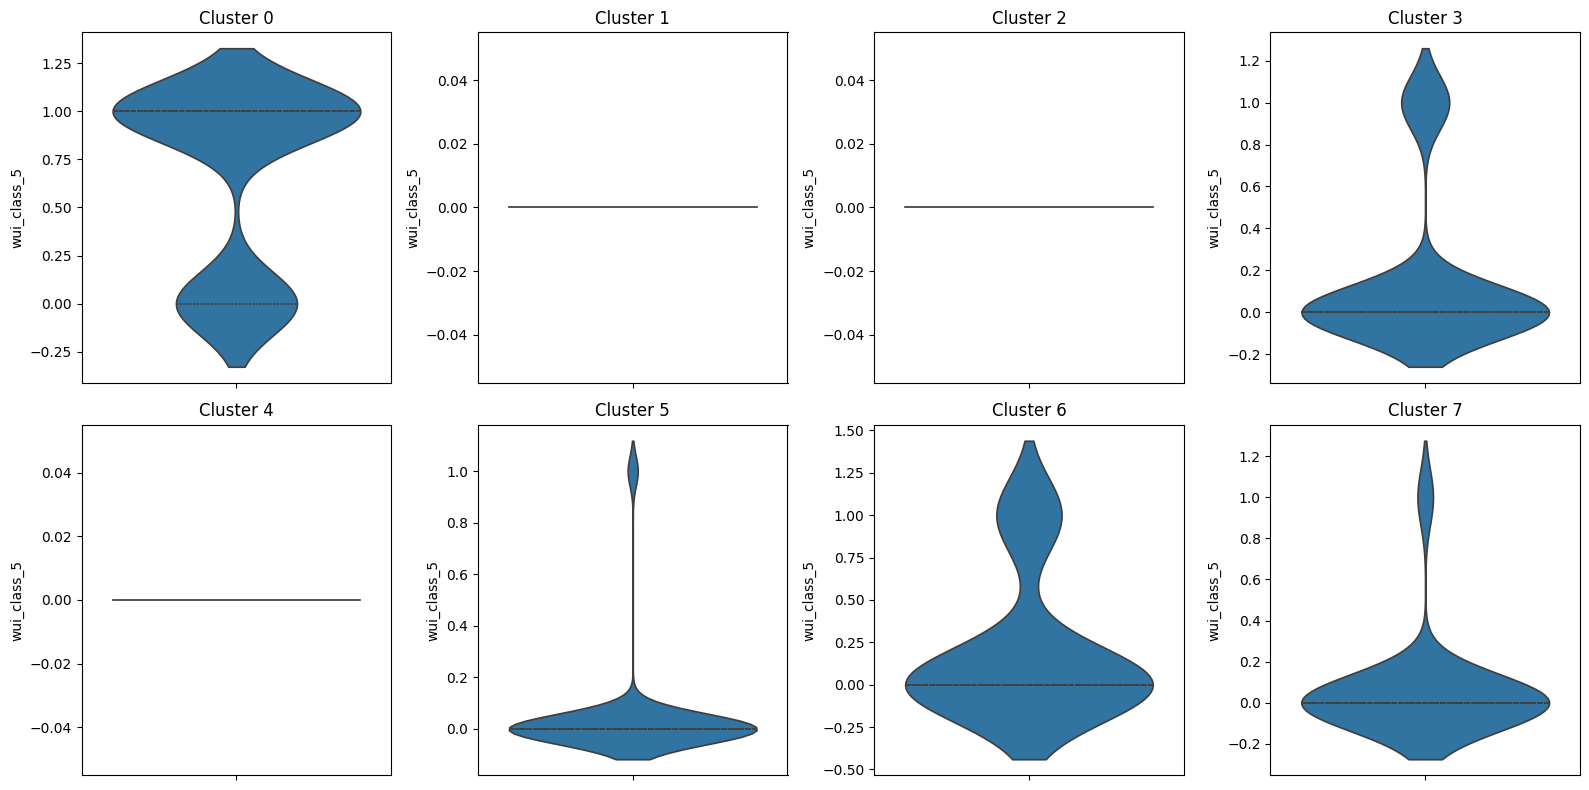

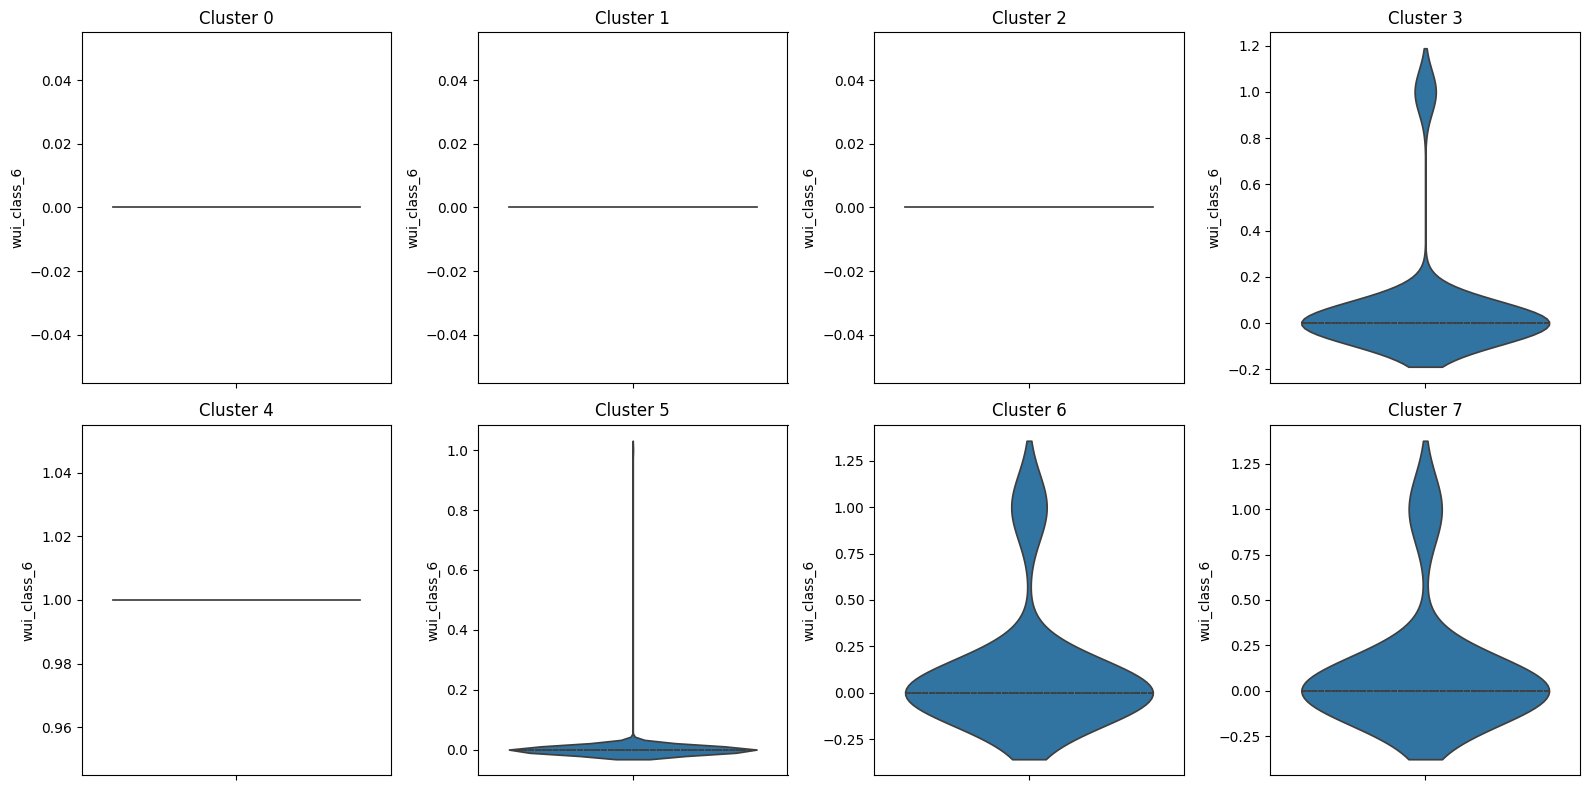

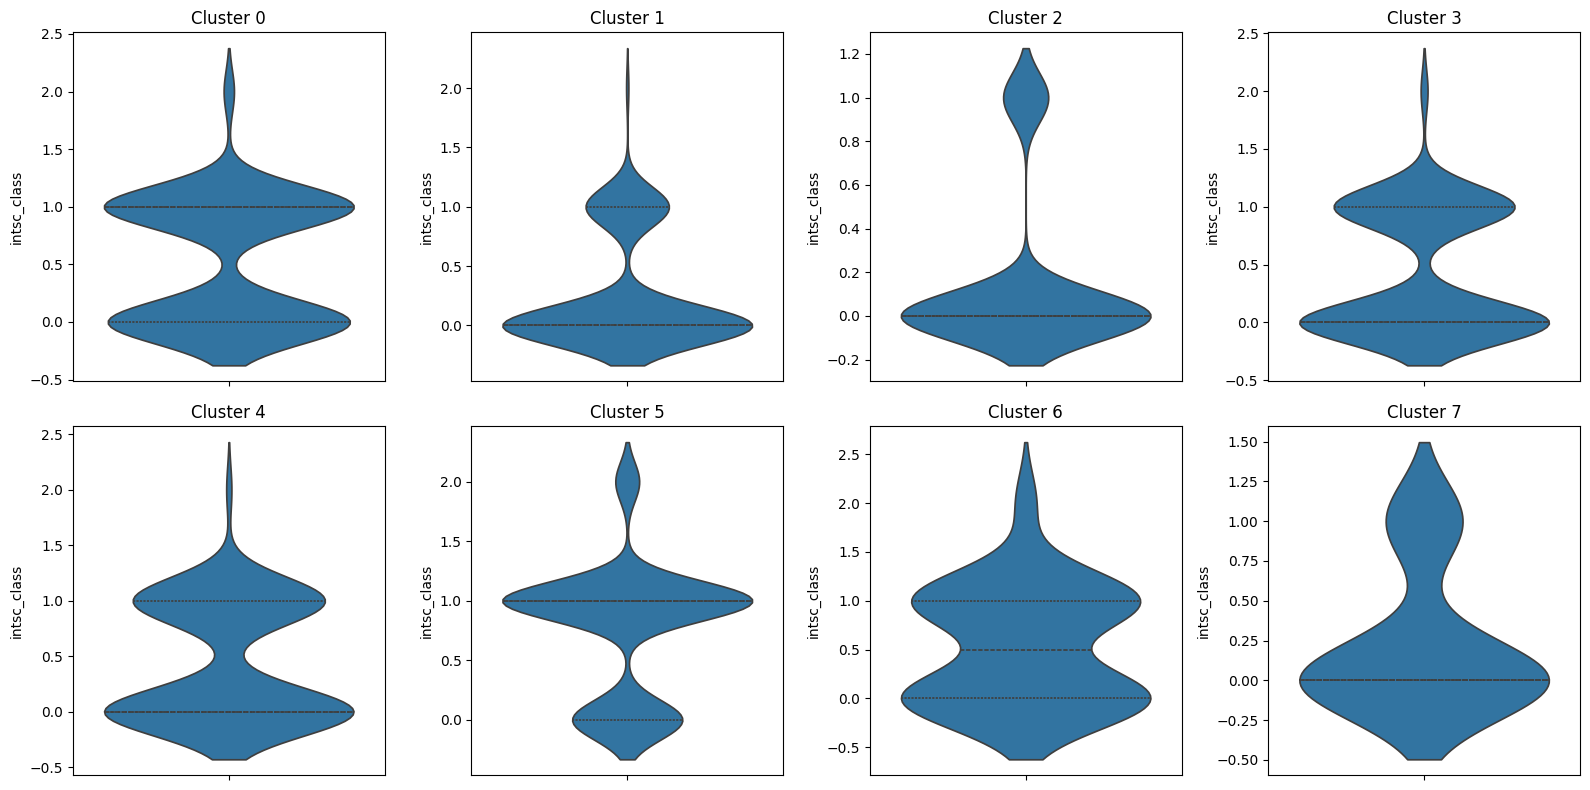

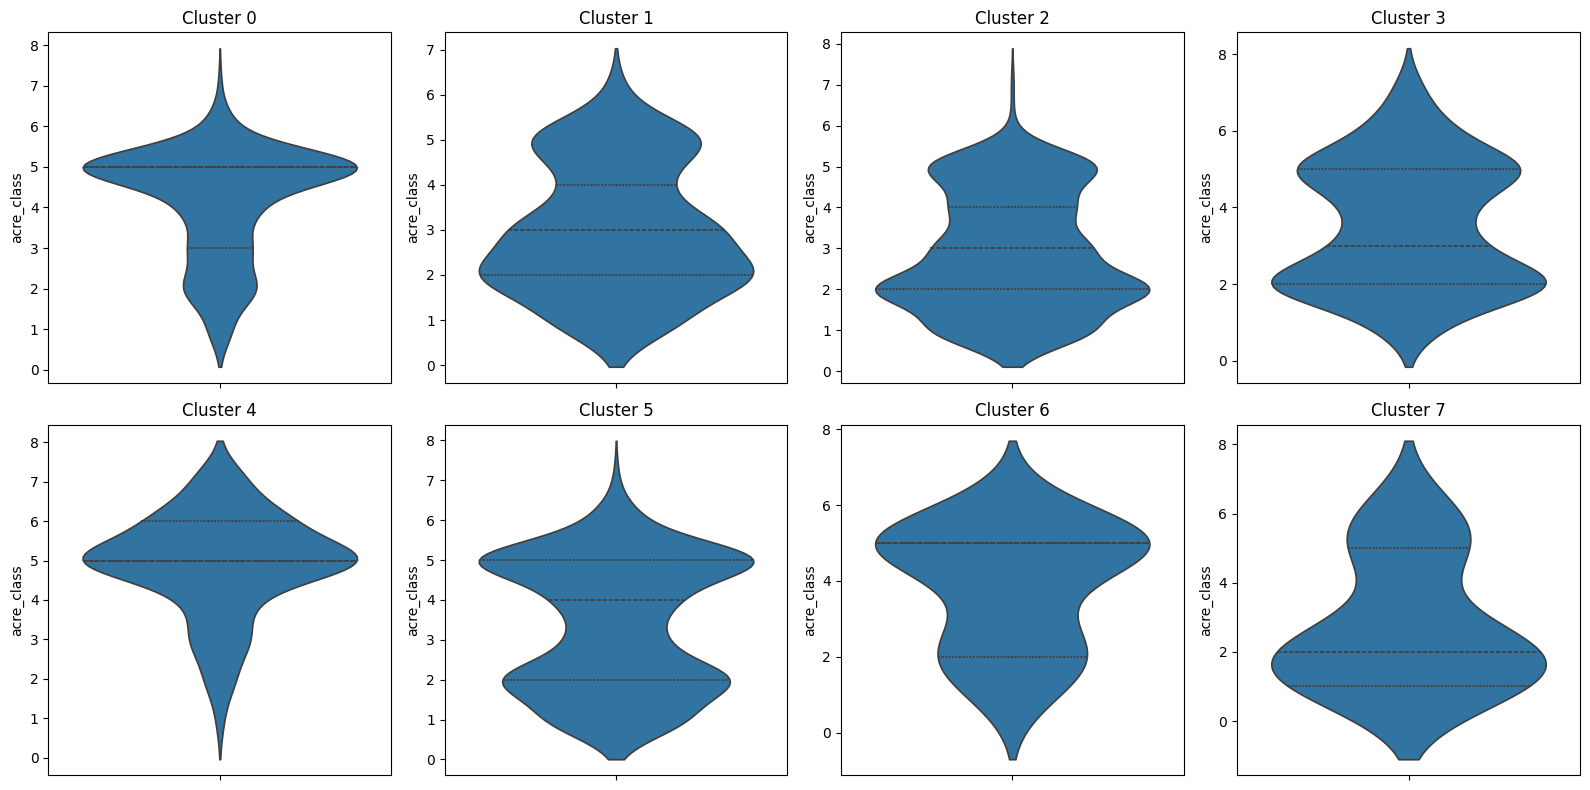

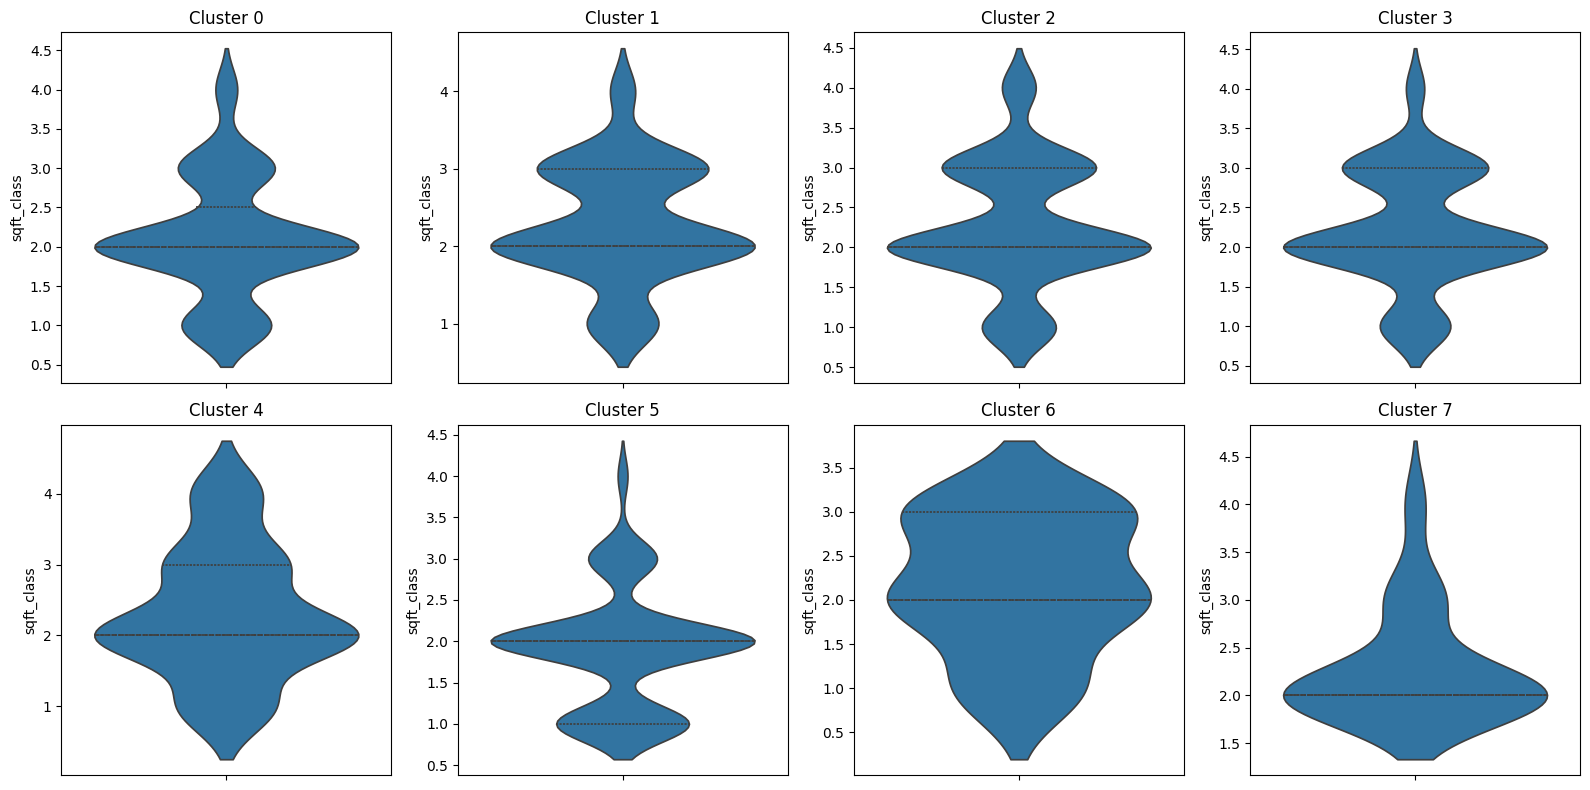

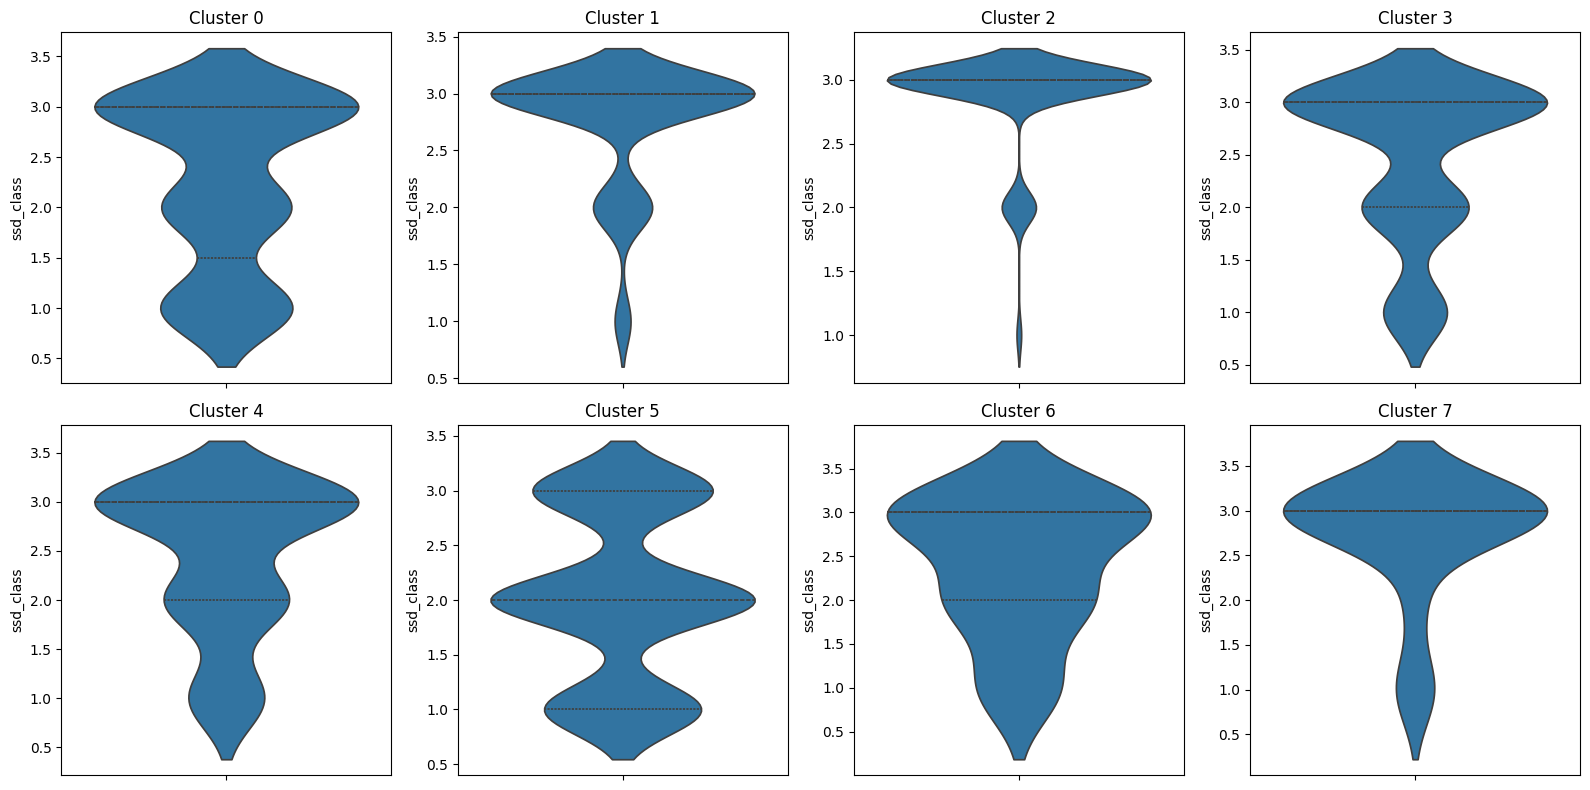

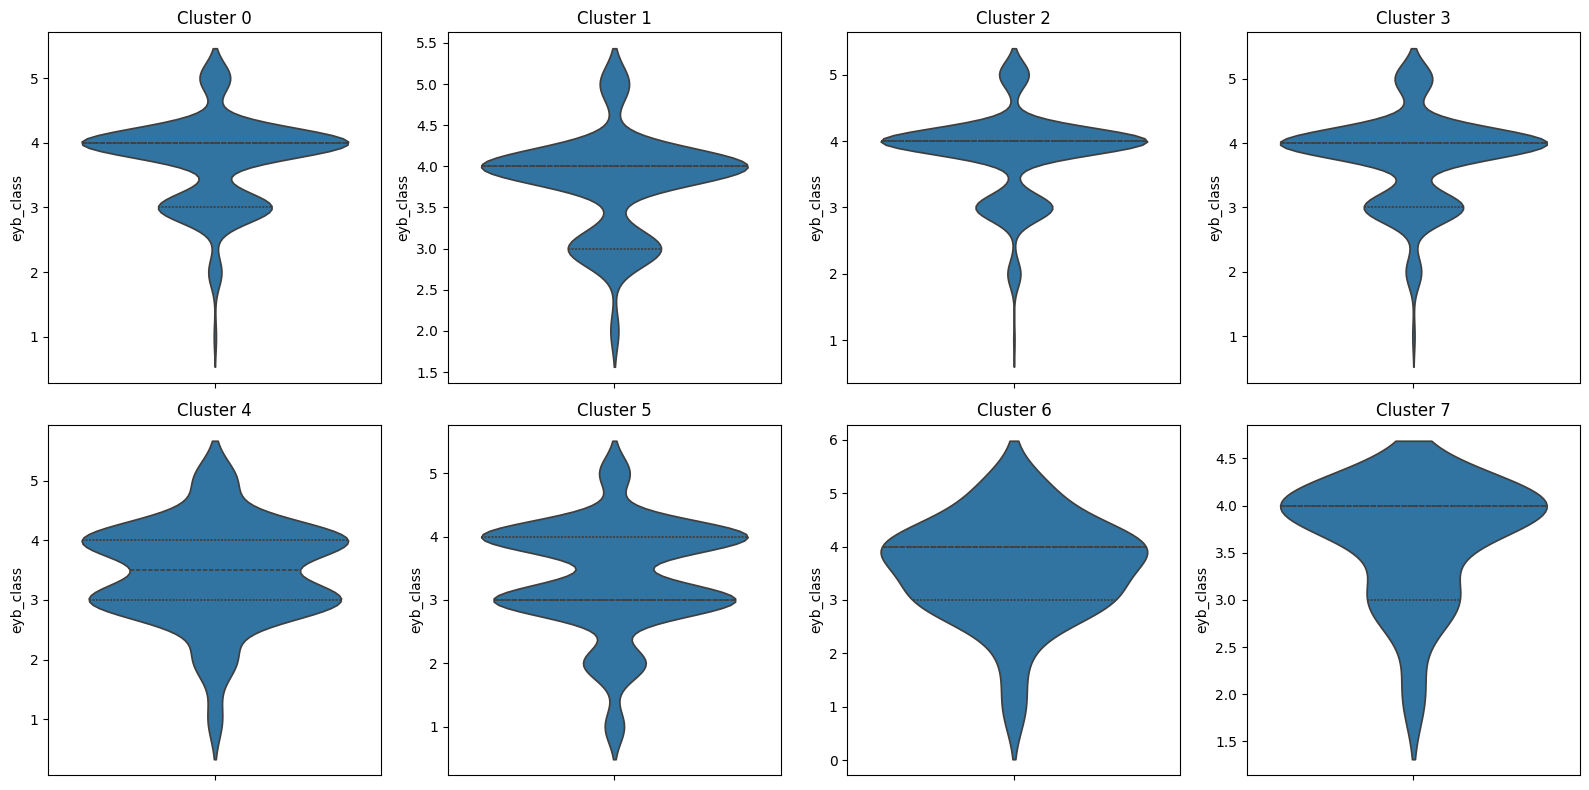

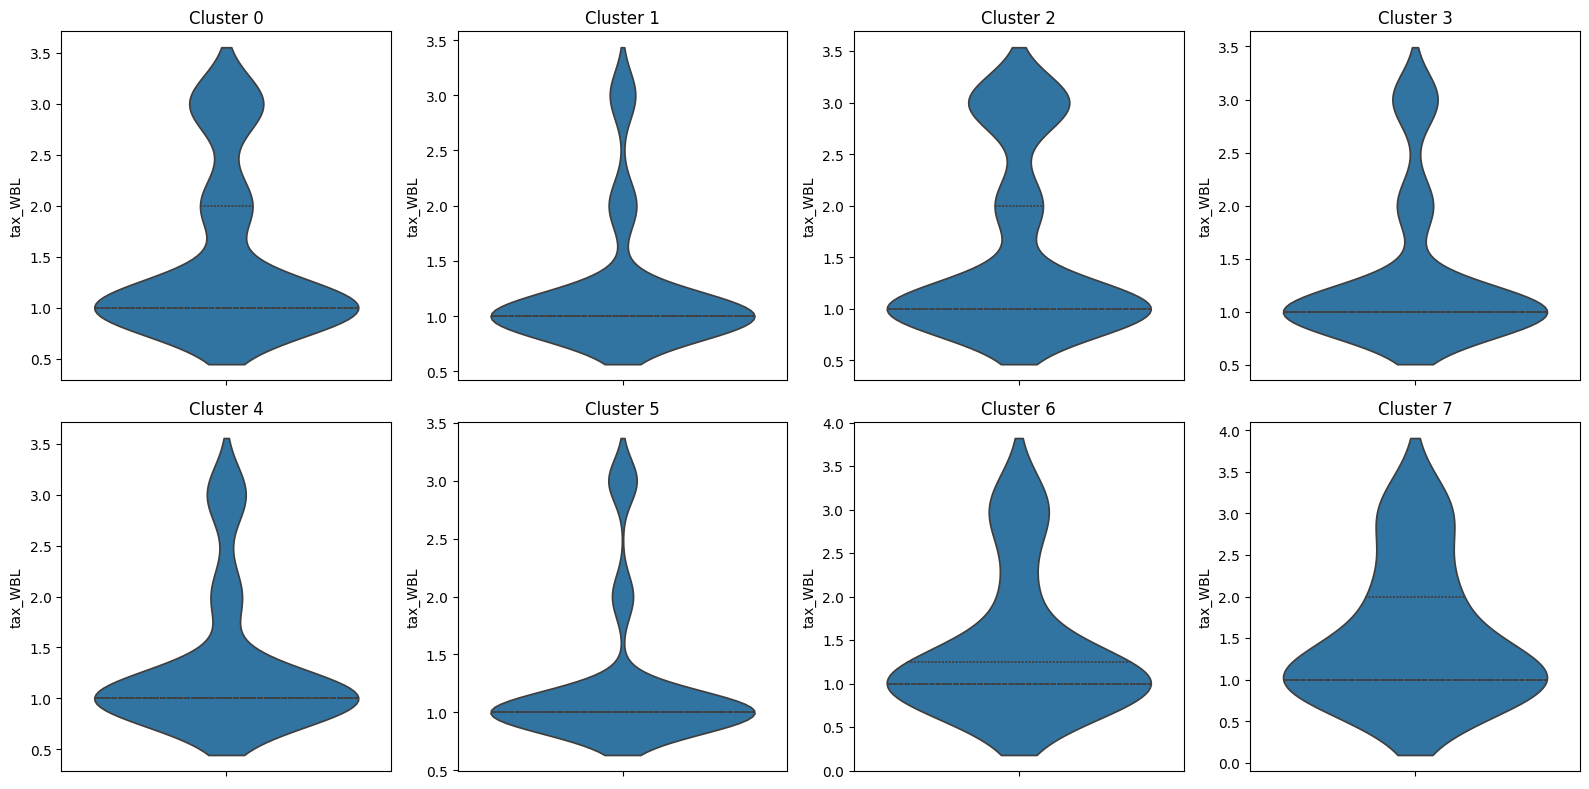

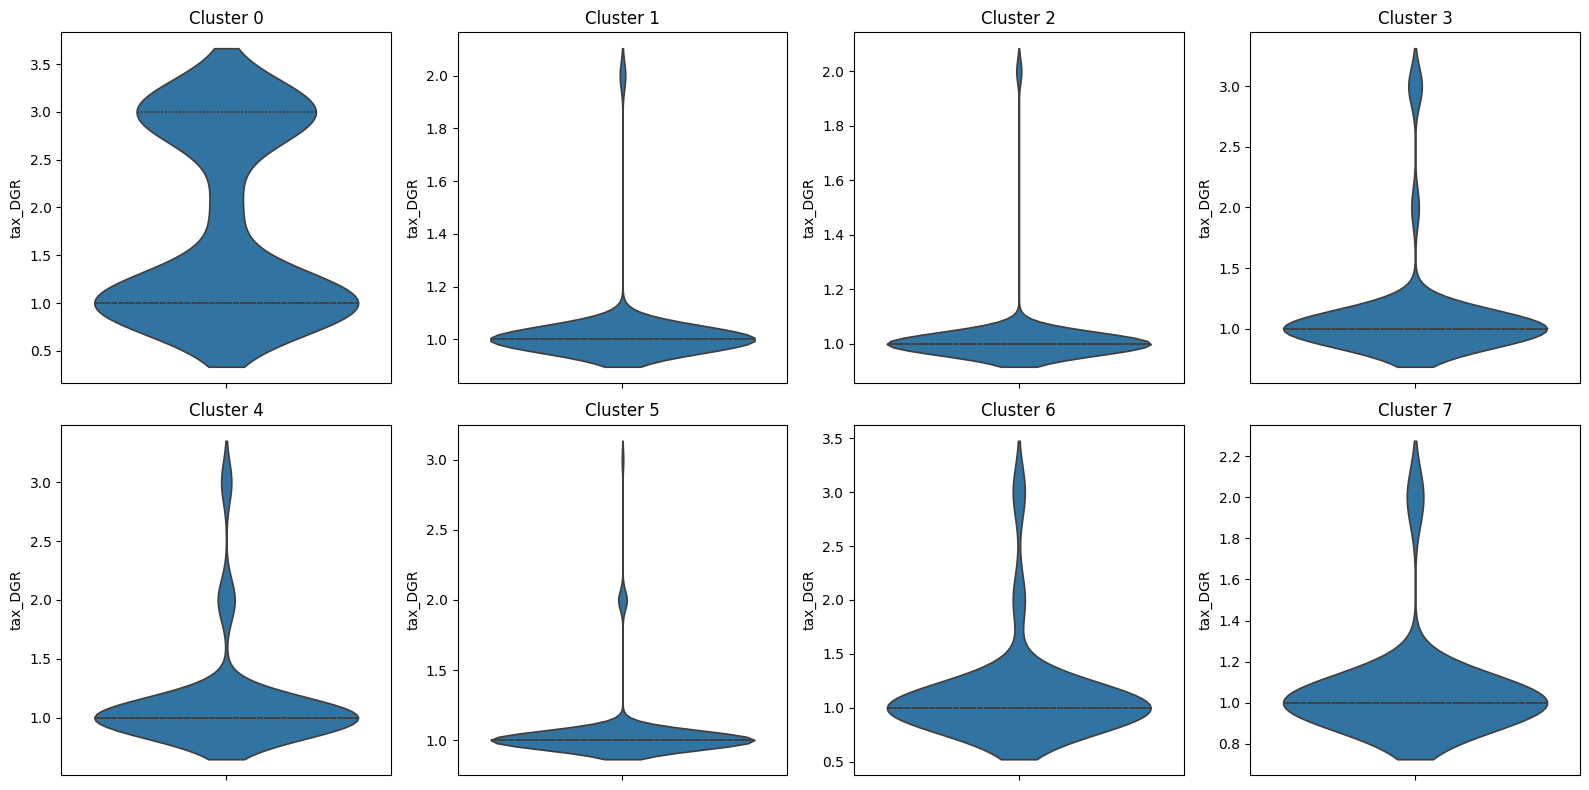

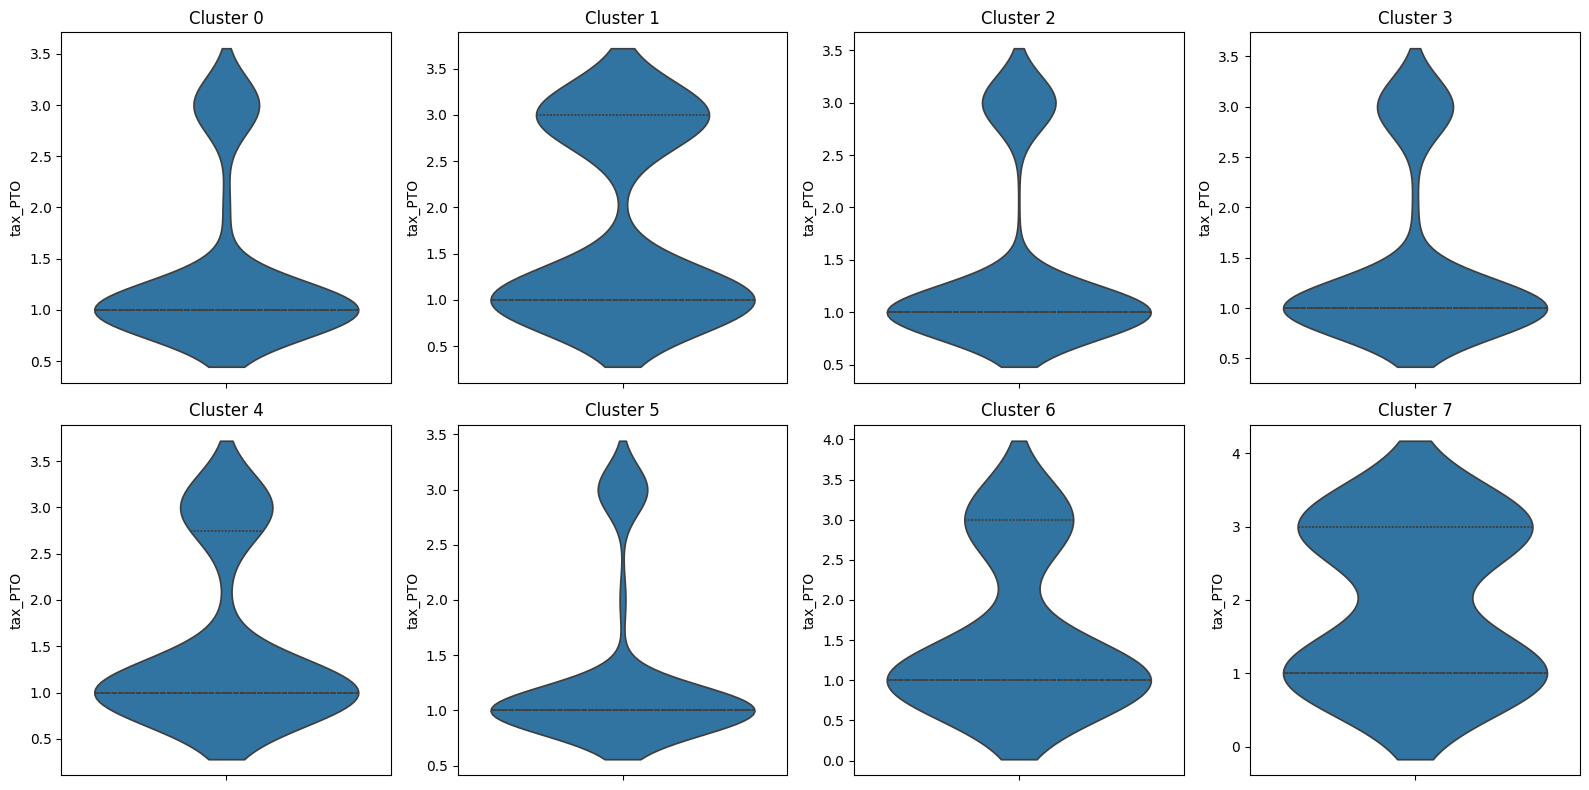

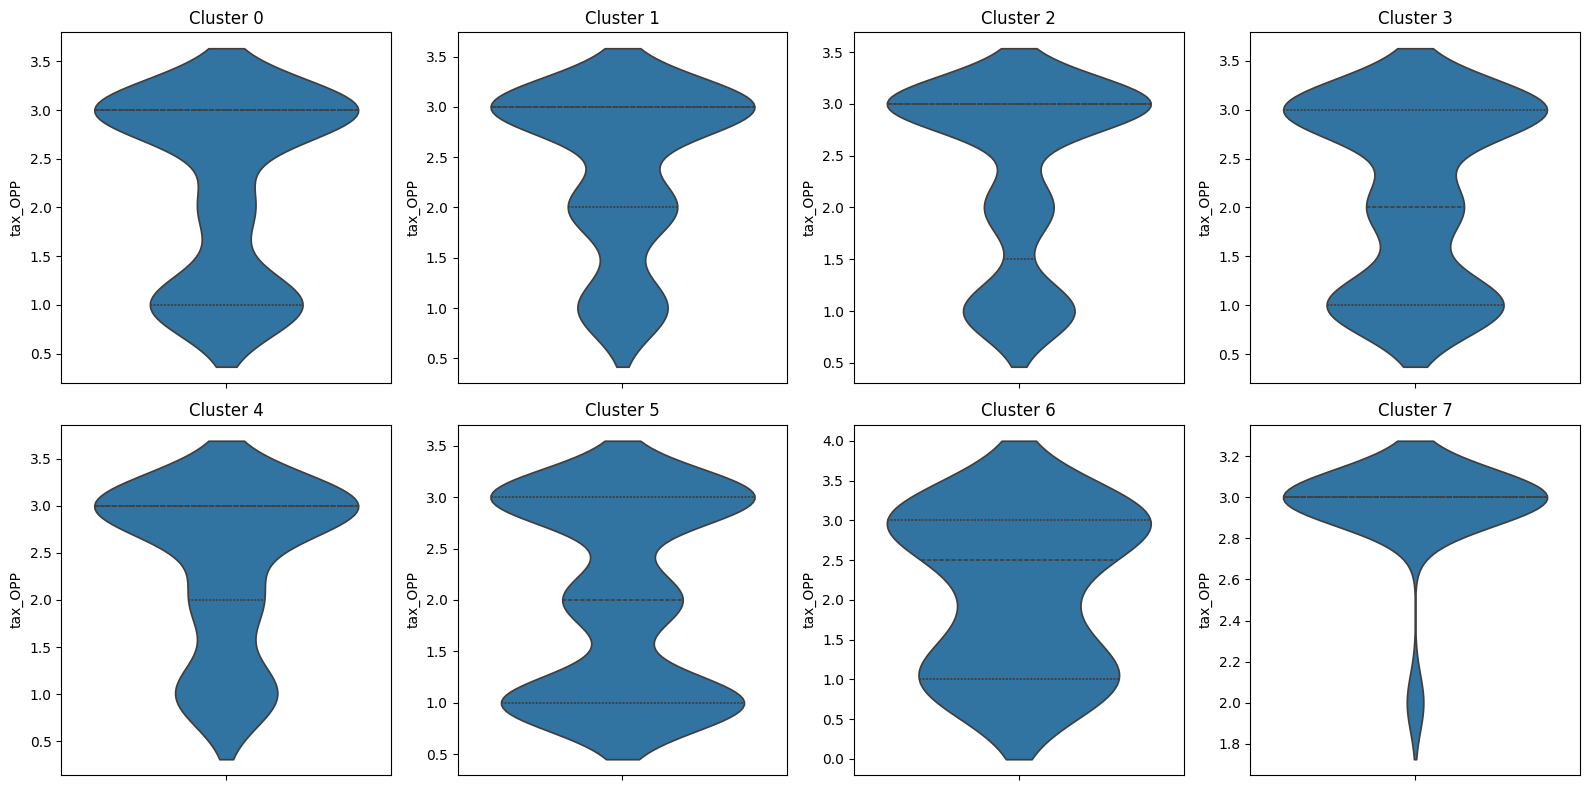

In [17]:
import seaborn as sns

def plot_feature_violins(feature, spc):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, df in enumerate(spc):
        sns.violinplot(y=df[feature], ax=axes[i], inner="quartile")
        axes[i].set_title(f"Cluster {i}")
        axes[i].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()

for feature in c_cols:
    plot_feature_violins(feature, spc)


My conclusion from these plots is that there is too much noise in my data for effective clustering. 

Cluster 7 is perhaps the only cluster containing describable features. It only contains 17 homes, and so the small cluster size may be beneficial to clustering in this type of dataset. I don't know if Ouray County has a particularly wide range of homes compared to other counties, but homes may be more easily clustered in more homogenous distributions of home and defensible space archetypes. The combinations of home and defensible space features may be too numerous to effectively segement and describe structure archetypes in general. However, future iterations of this workflow may be improved by reducing the number of features. By bringing out a few features, segmentation of structure archetypes is likely to be improved. 

I will need to go back to previous notebooks and re-do my feature selection for predictions and for clustering.